In [2]:
#############################################################
#
# NBA Individual Player Performance Prediction
#
#############################################################
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from mrsc.src.from_tslib.svdWrapper import SVDWrapper as SVD
from mrsc.src.from_tslib.tsSVDModel import SVDModel
from mrsc.src.from_tslib import tsUtils

from statsmodels.tsa.arima_model import ARMA

# for entropy
import zlib
import binascii
import re
import math

import pylab 
import scipy.stats as stats
from scipy.stats import entropy
from scipy.stats import bernoulli
from math import log, e
import timeit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'font.size': 14})

In [3]:
def page_mat(array, L, verbose=False):
    if verbose:
        print("input array length: ", len(array))
        print("output matrix rows: ", L)
        print("output matrix cols: ", int((len(array)-len(array)%L)/L))
        print("residuals         : ", len(array)%L)

    page = np.array([[]])
    page.shape = (L,0)
    for i in range(int((len(array)-len(array)%L)/L)):
        page = np.hstack((page, np.transpose([array[i*L:(i+1)*L]])))

    return page

def entropy1(labels, base=2):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

def window_stack(a, stepsize=1, width=3):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

def ts_estimate(preDF, postDF, player_name, nbrSingValuesToKeep):
#     player_data # array-like
    T = preDF.shape[0]
    L = int(np.floor(np.sqrt(len(list(preDF.values.flatten()))/10))) # nbr of rows
    M = int(T/L) # total nbr of columns
    res = T - M*L
    print("L: ", L)
    
    trainDF = preDF[res:]
    testDF = pd.concat([preDF[-(L-1):], postDF]).reset_index(drop=True)
    
    mod = SVDModel(player_name, nbrSingValuesToKeep, L, M, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
    mod.fit(trainDF)
    imputedDf = mod.denoisedDF()
    
    pred_matrix = window_stack(testDF, 1, L-1)
    pred = np.dot(pred_matrix, mod.weights)
    return pred

def mse(actual, pred):
    return ((actual - pred) ** 2).mean()

def rmse(actual, pred):
    return np.sqrt(((actual - pred) ** 2).mean())

def mape(actual, pred):
    actual = pd.DataFrame(actual)
    pred = pd.DataFrame(pred)
    mask = (actual != 0)
    return (np.abs(actual - pred) / actual[mask]).mean()

In [4]:
"""
import data
"""
print("*** importing data ***")

annual_pred = pd.read_pickle("annual_pred_2016.pkl")
target_players = list(annual_pred.columns)

data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

# edit column names to fit with the yearly data
data = data.rename(columns=colname_dict)

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

stats_game = data[["date","gmDate","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

df = pd.read_pickle("../data/nba-hosoi/nba_scores_2103-2018.pkl")
df = df[["nbaId","path","game_date","home","away","season"]].drop_duplicates().reset_index(drop=True)

a = pd.concat([df,(df["game_date"] + str(" ") + df["home"]).rename("key")], axis=1)
b = pd.concat([df,(df["game_date"] + str(" ") + df["away"]).rename("key")], axis=1)
appended = pd.concat([a,b], axis=0)

new_data = pd.concat([data, (data["gmDate"] + str(" ") + data["teamAbbr"]).rename("key")], axis=1)
data_fin = new_data.merge(appended, how='left', left_on='key', right_on='key')

stats_game = data_fin[["date","gmDate","gmTime","nbaId","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

player_list_1 = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
player_list_2 = ['Al Horford','Trevor Ariza','Eric Gordon']

*** importing data ***


# 1. Residual Page Matrix - using EWMA filter

In [188]:
def run_ewma(vals, window=3):
    # take EWMA in both directions with a smaller span term
    fwd = pd.DataFrame(vals).ewm(span=window).mean().values.flatten() # take EWMA in fwd direction
    bwd = pd.DataFrame(vals[::-1]).ewm(span=window).mean().values.flatten() # take EWMA in bwd direction
    runs_smoothed = 0.7 * fwd + 0.3 * bwd[::-1]
#     return runs_smoothed
    return fwd
#     return bwd[::-1]

Stephen Curry


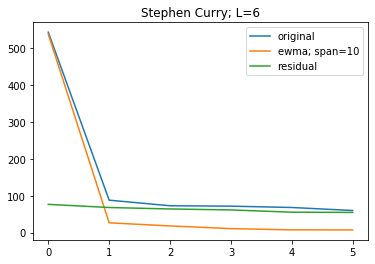

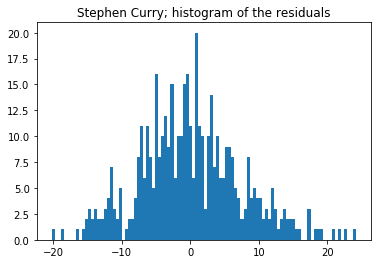

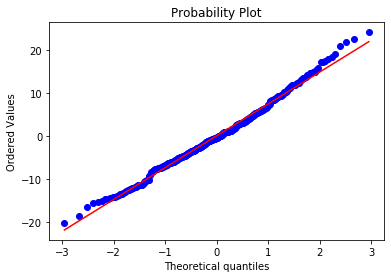

Kevin Durant


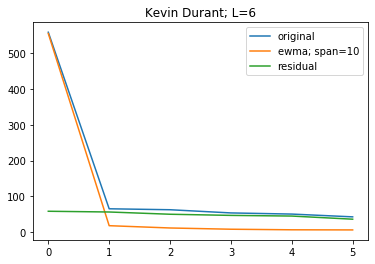

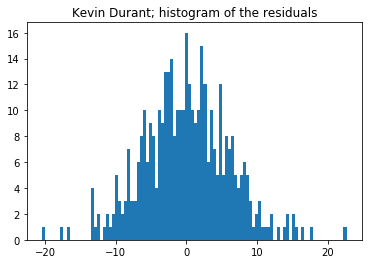

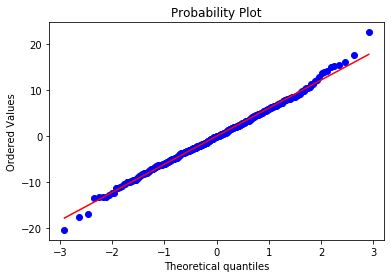

LeBron James


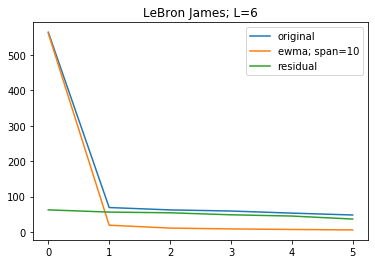

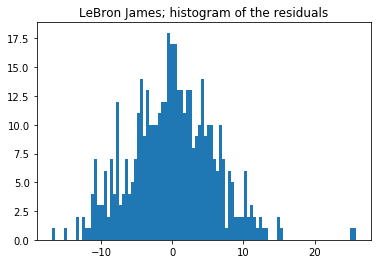

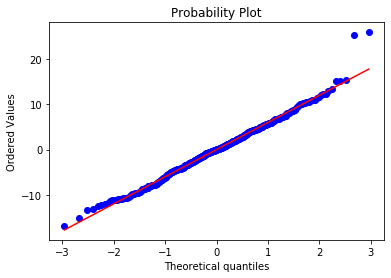

Russell Westbrook


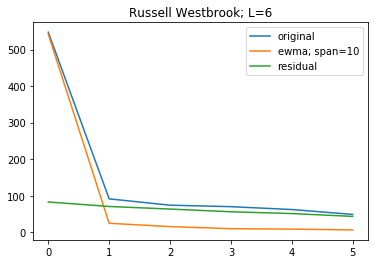

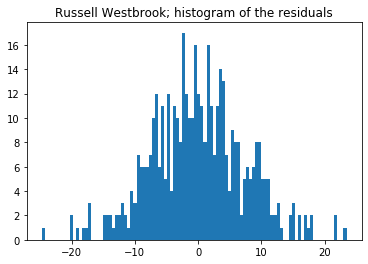

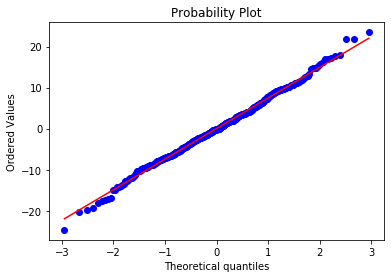

James Harden


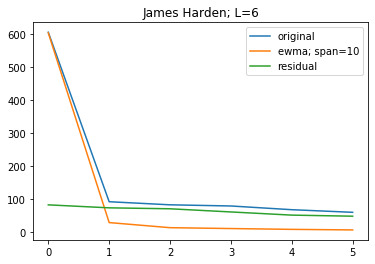

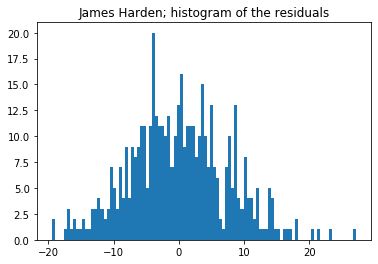

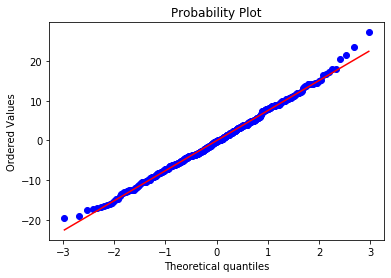

Paul George


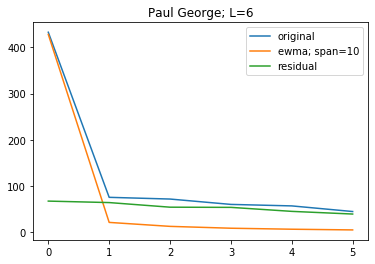

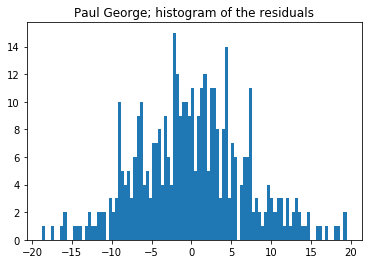

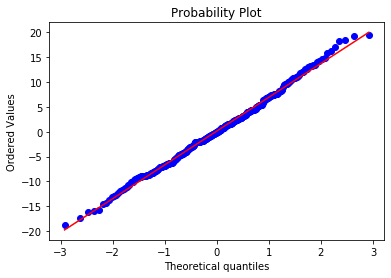

Kyrie Irving


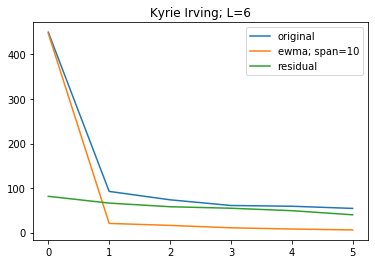

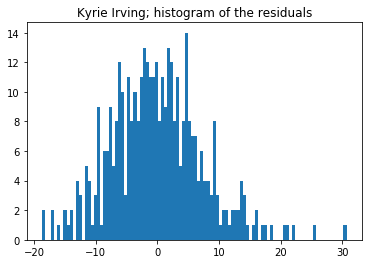

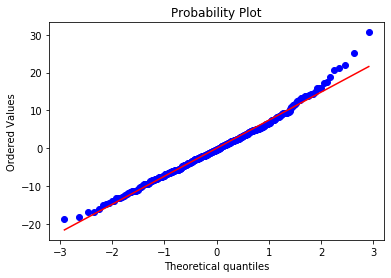

Chris Paul


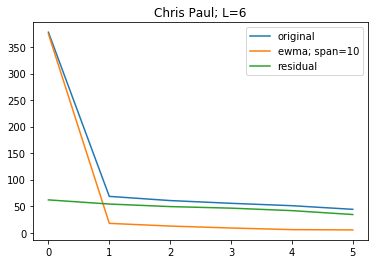

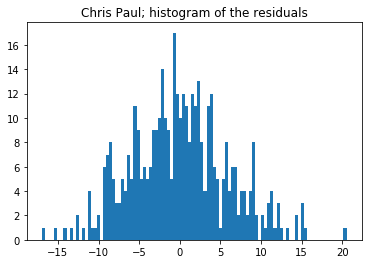

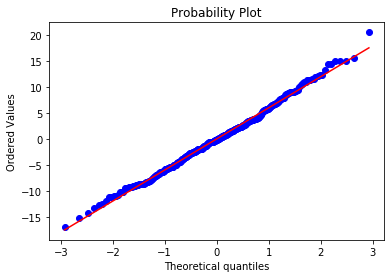

In [189]:
metric = "PTS_G"
span = 10

#############
for player_name in player_list_1:
    print(player_name)
    player_stat = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
#     player_stat_ewma = player_stat.ewm(span=span).mean()
    player_stat_ewma = run_ewma(player_stat, span)
    player_stat_ewma = pd.Series(player_stat_ewma, name=player_name)
    player_residual = (player_stat - player_stat_ewma)
    
    L = int(np.floor(np.sqrt(len(player_stat.to_list())/10)))
    
    player_page = page_mat(player_stat.to_list(), L)
    u, s_original, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_stat_ewma.to_list(), L)
    u, s_ewma, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_residual.to_list(), L)
    u, s_residual, vh = np.linalg.svd(player_page)
    
    # sigval spectrum
    plt.title(player_name+"; L={}".format(L))
    # plt.ylim(0,100)
    plt.plot(s_original, label= "original")
    plt.plot(s_ewma, label="ewma; span={}".format(span))
    plt.plot(s_residual, label="residual")
    plt.legend()
    plt.show()
    
    # histogram
    plt.title(player_name+"; histogram of the residuals")
    plt.hist(player_residual, bins=100)
    plt.show()
    
    # qq plot
    stats.probplot(player_residual, dist="norm", plot=pylab)
    pylab.show()



------------------------------------------------------------------


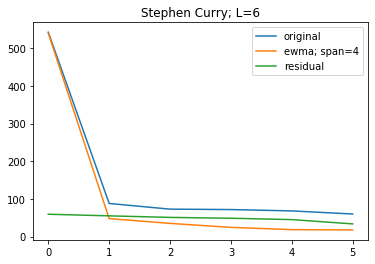

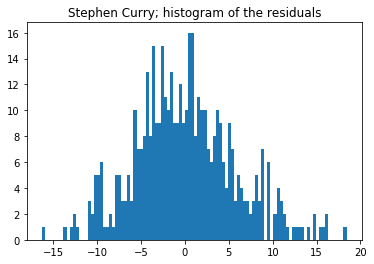

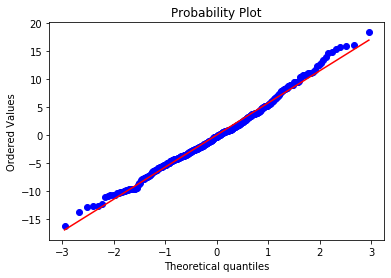

L:  6


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


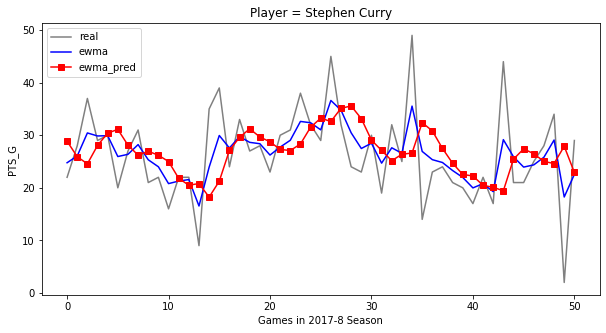

Stephen Curry
*** RMSE compared to ewma ***
first 0-5 games:  3.308672425950589
first 5-10 games:  2.8696958755881985
first 10-20 games:  3.9234131794320213
all           :  3.837306301614523

Stephen Curry
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  2.2161070264922564
first 5-10 games:  2.427572330040462
first 10-20 games:  3.7197507378792123
all           :  3.790074515468056
Stephen Curry
*** RMSE compared to actual***
first 0-5 games:  6.435841644275849
first 5-10 games:  6.33562951111719
first 10-20 games:  9.278883081073383
all           :  9.282974159711875
Stephen Curry
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  6.099180272790763
first 5-10 games:  7.293833011524188
first 10-20 games:  11.29601699715435
all           :  12.366146070116226

------------------------------------------------------------------


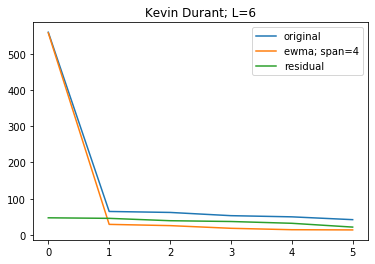

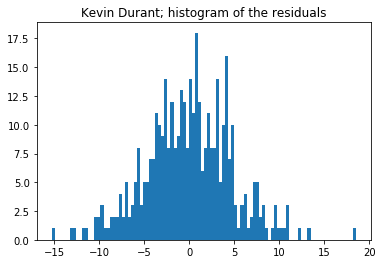

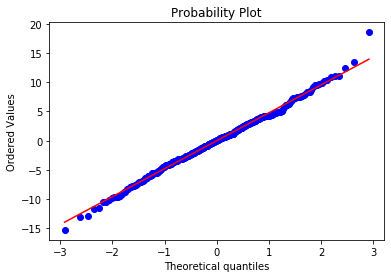

L:  5


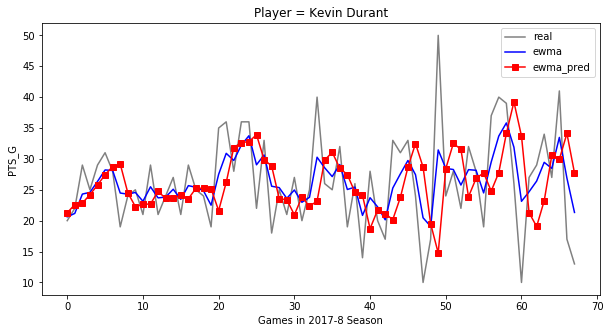

Kevin Durant
*** RMSE compared to ewma ***
first 0-5 games:  1.008940926079385
first 5-10 games:  2.38229705699639
first 10-20 games:  1.536324266952315
all           :  4.241712442593779

Kevin Durant
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  1.6415119348174427
first 5-10 games:  1.839026179242463
first 10-20 games:  1.6072624614597357
all           :  3.428880631122321
Kevin Durant
*** RMSE compared to actual***
first 0-5 games:  3.1940422503907926
first 5-10 games:  4.988932527391675
first 10-20 games:  3.835593071496738
all           :  9.179271275444272
Kevin Durant
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  5.761944116355173
first 5-10 games:  4.898979485566356
first 10-20 games:  5.513619500836088
all           :  10.369638940903675

------------------------------------------------------------------


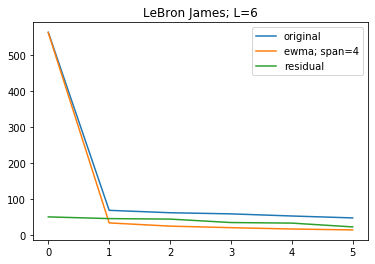

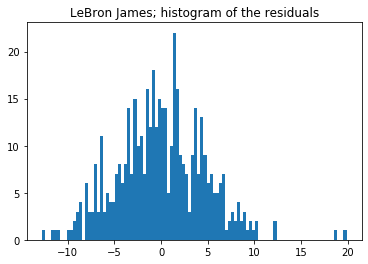

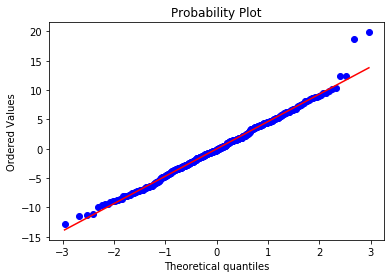

L:  6


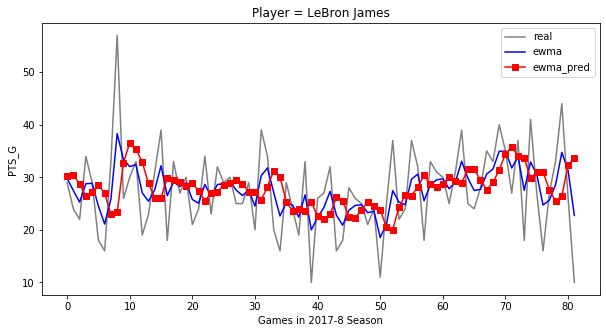

LeBron James
*** RMSE compared to ewma ***
first 0-5 games:  2.425701600030552
first 5-10 games:  7.536310234481423
first 10-20 games:  3.567598476861403
all           :  3.8388908847797643

LeBron James
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  2.12619265501129
first 5-10 games:  6.818770193462451
first 10-20 games:  3.148602731301138
all           :  3.592789721619059
LeBron James
*** RMSE compared to actual***
first 0-5 games:  5.466309313506115
first 5-10 games:  17.385084437210917
first 10-20 games:  7.922224150611415
all           :  8.987178564033107
LeBron James
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  6.434283176858165
first 5-10 games:  19.75348070594142
first 10-20 games:  10.373041983911952
all           :  11.056396449070755

------------------------------------------------------------------


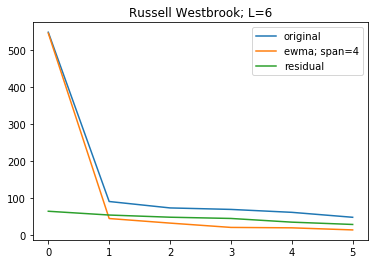

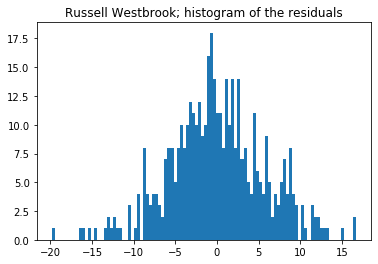

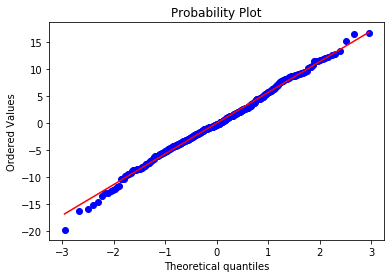

L:  5


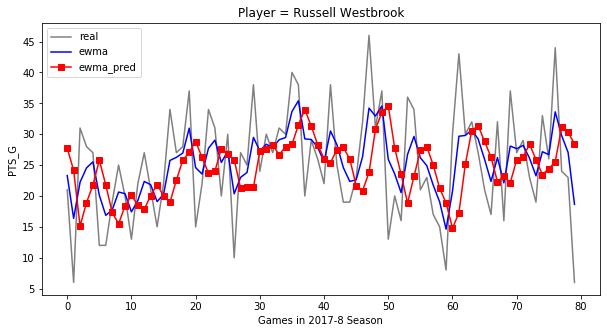

Russell Westbrook
*** RMSE compared to ewma ***
first 0-5 games:  5.932255644826026
first 5-10 games:  4.168646906648345
first 10-20 games:  3.3946861106058908
all           :  4.4466195510113335

Russell Westbrook
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  4.260040302301257
first 5-10 games:  3.1323150143306506
first 10-20 games:  2.790419716955646
all           :  3.7933687791055775
Russell Westbrook
*** RMSE compared to actual***
first 0-5 games:  12.133458166366914
first 5-10 games:  8.733204273640128
first 10-20 games:  7.4038637854819855
all           :  9.932895093475086
Russell Westbrook
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  14.939879517586478
first 5-10 games:  8.18535277187245
first 10-20 games:  7.422937423958254
all           :  11.25

------------------------------------------------------------------


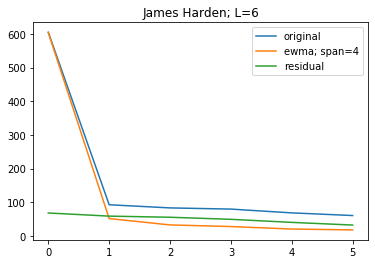

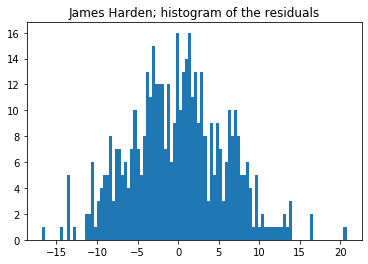

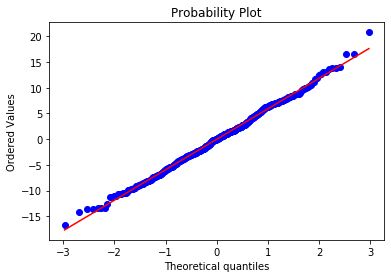

L:  6


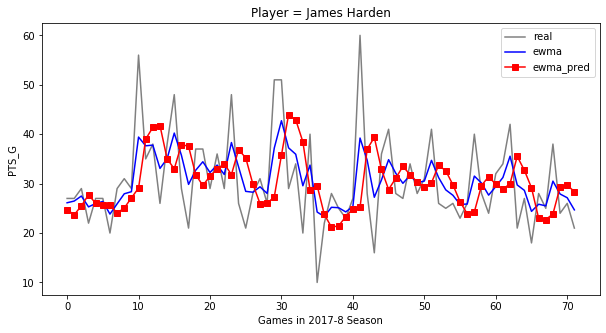

James Harden
*** RMSE compared to ewma ***
first 0-5 games:  1.9786016078289475
first 5-10 games:  1.857872892382915
first 10-20 games:  5.8033265882674065
all           :  4.735848643458666

James Harden
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  1.1632225858752245
first 5-10 games:  1.7498564943933357
first 10-20 games:  4.943556748972665
all           :  4.05623698750394
James Harden
*** RMSE compared to actual***
first 0-5 games:  3.526169794355265
first 5-10 games:  4.414468891586541
first 10-20 games:  12.915893282199214
all           :  10.5374920878741
James Harden
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  3.9496835316262997
first 5-10 games:  5.253570214625479
first 10-20 games:  14.99333185119305
all           :  12.504443654601795

------------------------------------------------------------------


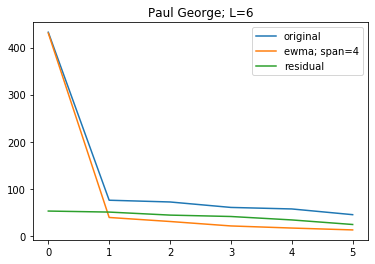

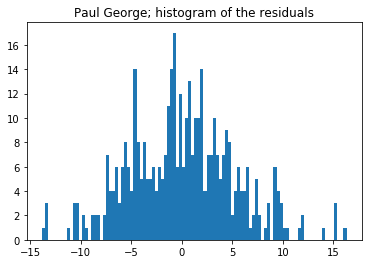

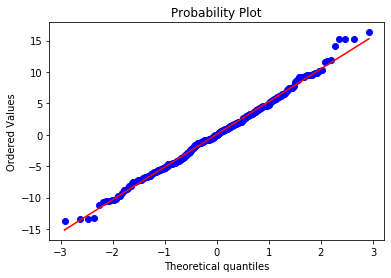

L:  5


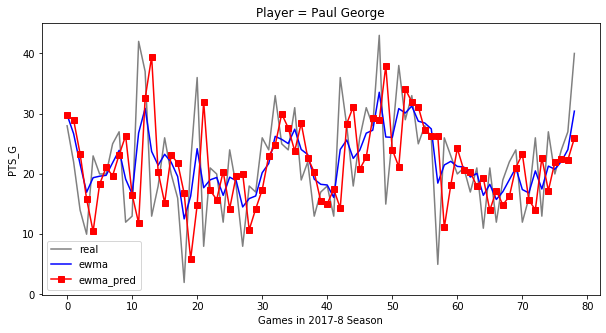

Paul George
*** RMSE compared to ewma ***
first 0-5 games:  4.2179105592930695
first 5-10 games:  3.4677962608139428
first 10-20 games:  8.206741131925197
all           :  5.276459731635661

Paul George
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  3.5878938368200903
first 5-10 games:  2.5059203441790108
first 10-20 games:  5.060015519233433
all           :  3.5751090161638137
Paul George
*** RMSE compared to actual***
first 0-5 games:  8.123516657563925
first 5-10 games:  7.096583899996789
first 10-20 games:  15.118044867335946
all           :  10.153810426661014
Paul George
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  7.758865896508329
first 5-10 games:  7.252585745787498
first 10-20 games:  14.7648230602334
all           :  10.83711391352345

------------------------------------------------------------------


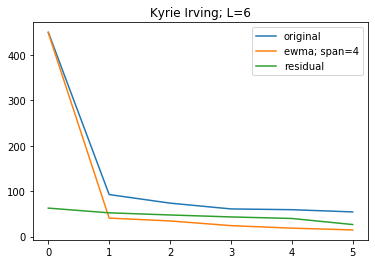

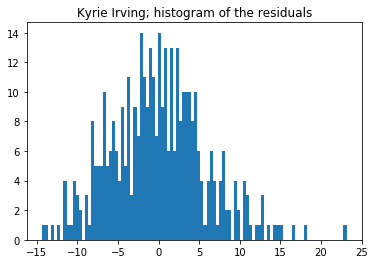

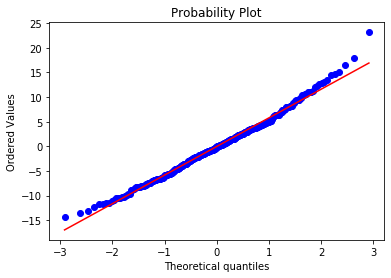

L:  5


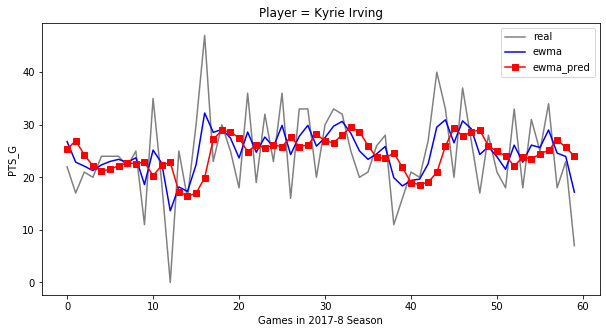

Kyrie Irving
*** RMSE compared to ewma ***
first 0-5 games:  2.265800518420945
first 5-10 games:  2.1595309224452994
first 10-20 games:  5.423788222414369
all           :  3.567961213194625

Kyrie Irving
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  2.368067010508866
first 5-10 games:  2.3444182025468816
first 10-20 games:  5.407357585891836
all           :  3.6841042274487315
Kyrie Irving
*** RMSE compared to actual***
first 0-5 games:  5.1728473816835345
first 5-10 games:  5.612310464263122
first 10-20 games:  13.203954199197874
all           :  8.867156463459029
Kyrie Irving
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  10.83512805646523
first 5-10 games:  6.465291950097845
first 10-20 games:  17.418381095842403
all           :  12.041594578792296

------------------------------------------------------------------


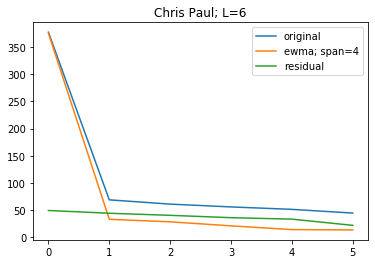

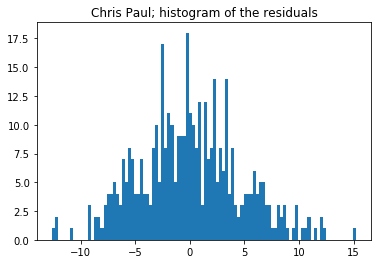

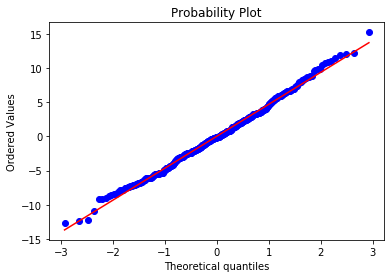

L:  5


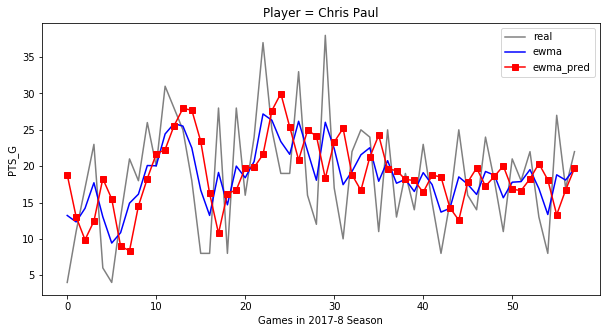

Chris Paul
*** RMSE compared to ewma ***
first 0-5 games:  4.609807909498407
first 5-10 games:  4.222749462626028
first 10-20 games:  4.217399566739324
all           :  3.9578183474614304

Chris Paul
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  3.9091695254465164
first 5-10 games:  3.119088812031125
first 10-20 games:  3.991660676005196
all           :  3.4210633849538605
Chris Paul
*** RMSE compared to actual***
first 0-5 games:  10.367457299237461
first 5-10 games:  8.711514951259122
first 10-20 games:  9.927849193966892
all           :  8.899025406184585
Chris Paul
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  10.761040841851685
first 5-10 games:  6.663332499583072
first 10-20 games:  12.345039489608771
all           :  10.669809163532724


In [7]:
# player_name = "LeBron James"
# L = 10

metric = "PTS_G"
span = 4
nbrSingValuesToKeep = 2
xlabel = 'Games in 2017-8 Season'
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"

#############
for player_name in player_list_1:
    print()
    print("------------------------------------------------------------------")
    player_stat = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
#     player_stat_ewma = player_stat.ewm(span=span).mean()
    player_stat_ewma = run_ewma(player_stat, span)
    player_stat_ewma = pd.Series(player_stat_ewma, name=player_name)
    player_residual = (player_stat - player_stat_ewma)
    
    L = int(np.floor(np.sqrt(len(player_stat.to_list())/10)))
    
    player_page = page_mat(player_stat.to_list(), L)
    u, s_original, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_stat_ewma.to_list(), L)
    u, s_ewma, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_residual.to_list(), L)
    u, s_residual, vh = np.linalg.svd(player_page)
    
    # singval spectrum
    plt.title(player_name+"; L={}".format(L))
    plt.plot(s_original, label= "original")
    plt.plot(s_ewma, label="ewma; span={}".format(span))
    plt.plot(s_residual, label="residual")
    plt.legend()
    plt.show()
    
    # histogram
    plt.title(player_name+"; histogram of the residuals")
    plt.hist(player_residual, bins=100)
    plt.show()
    
    # qq plot
    stats.probplot(player_residual, dist="norm", plot=pylab)
    pylab.show()
    
    # prediction plot
    plt.figure(figsize=(10,5))
    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]

    # true data
    player_data = player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    preDF = player_stat.loc[player_stat.date <= interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    postDF = player_stat.loc[player_stat.date > interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    n = preDF.shape[0]
    plt.plot(postDF, label="real", color="grey")

    # ewma data
    # player_data_ewma = player_data.ewm(span=span).mean()
    player_data_ewma = run_ewma(player_data, span)
    player_data_ewma = pd.DataFrame(player_data_ewma, columns=[player_name])
    preDF_ewma = player_data_ewma[:n].reset_index(drop=True)
    postDF_ewma = player_data_ewma[n:].reset_index(drop=True)
    plt.plot(postDF_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred = ts_estimate(preDF_ewma, postDF_ewma, player_name, nbrSingValuesToKeep)
    plt.plot(ts_pred[:-1], label="ewma_pred", color="red", marker='s')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.title('Player = '+player_name)
    plt.show()

    true = postDF_ewma.values.flatten()
    print(player_name)
    print("*** RMSE compared to ewma ***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    print()
    
    pred = postDF_ewma.shift(+1).values
    pred[0] = preDF_ewma.iloc[-1]
    true = postDF_ewma.values
    print(player_name)
    print("*** RMSE baseline for ewma (pred = last observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]))
    print("all           : ", rmse(true, pred))
    
    true = postDF.values.flatten()
    print(player_name)
    print("*** RMSE compared to actual***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    
    pred = postDF.shift(+1).values
    pred[0] = preDF.iloc[-1]
    true = postDF.values
    print(player_name)
    print("*** RMSE baseline for actual (pred = last observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]))
    print("all           : ", rmse(true, pred))
    

# 2. Binary String Test - Entropy

In [5]:
def get_delta(x):
    delta = np.zeros(len(x)-1)
    delta[(x - x.shift(+1))[1:]>0] = 1
    # 1 = increase
    # 0 = not increase (decrease or stays the same)
    delta = delta.astype(int)
    return list(delta)
    
def calculate_compress_rate(x, quality):

    compressed_data = zlib.compress(bytes(x), quality)
    ratio = len(compressed_data)/len(bytes(x))

    print("original size   : ", len(bytes(x)))
    print("compressed size : ", len(compressed_data))
    print("ratio           : ", ratio)

    return compressed_data

def calculate_decompress_error(original, compressed):
    decompress = list(zlib.decompress(compressed))
    error = np.sum(original != decompress)
    print("decompress error: ", error/len(original))
    return decompress

def zlib_test(delta, quality):
    print("- using zlib")
    delta_compressed = calculate_compress_rate(delta, quality)
    delta_decompressed = calculate_decompress_error(delta, delta_compressed)
    
def compress(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
#     dictionary = dict((chr(i), i) for i in range(dict_size))
    # in Python 3: dictionary = {chr(i): i for i in range(dict_size)}
#     print(dictionary)
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result

def decompress(compressed):
    """Decompress a list of output ks to a string."""
    from io import StringIO
 
    # Build the dictionary.
    dict_size = 256
    dictionary = dict((i, chr(i)) for i in range(dict_size))
    # in Python 3: dictionary = {i: chr(i) for i in range(dict_size)}
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)
 
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result.getvalue()

def lzw_test(delta):
    delta_string = re.sub('\W+','', str(delta) )
    delta_compressed = compress(delta_string)
    delta_decompressed = decompress(delta_compressed)
    ratio = len(delta_compressed)/len(delta_string)
    error = np.sum(np.array([int(i) for i in delta_string]) != np.array([int(i) for i in delta_decompressed]))
    
    print("- using lzw")
    print("original size   : ", len(delta))
#     print(delta_string)
    print("compressed size : ", len(delta_compressed))
#     print(delta_compressed)
    print("ratio           : ", ratio)
    print("error           : ", error/len(delta_string))

In [12]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
quality = 9 # best but slow
span = 3
#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = get_delta(player_data)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    print("p = ", p)
    print()

    print("* original - X(t) list")
    player_delta = get_delta(player_data)
    zlib_test(player_delta, quality)
    lzw_test(player_delta)
    print()

    print("* 111110000 list")
    ones = np.ones(int(p*len(player_delta)))
    zeros = np.zeros(len(player_delta) - len(ones))
    easy_delta = np.concatenate([ones, zeros]).astype(int)
    zlib_test(list(easy_delta), quality)
    lzw_test(list(easy_delta))
    print()

    print("* random list")
    hard_delta = bernoulli.rvs(p, size=len(player_delta))
    zlib_test(list(hard_delta), quality)
    lzw_test(list(hard_delta))
    print()

    print("-------------------")

    print("* low pass filter - EWMA(t) list")
    player_data_ewma = run_ewma(player_data, span)
    player_delta = get_delta(pd.Series(player_data_ewma))
    zlib_test(player_delta, quality)
    lzw_test(player_delta)
    print()
    
    print("-------------------")

    print("* residuals = X(t) - EWMA(t) list")
    player_data_residual = player_data - player_data_ewma
    player_data_residual[player_data_residual<0] = 0
    player_data_residual[player_data_residual>0] = 1
    player_data_residual = player_data_residual.astype(int)
#     print(player_data_residual)
    zlib_test(player_data_residual, quality)
    lzw_test(player_delta)
    print()

    print("===================")

Stephen Curry
p =  0.5022522522522522

* original - X(t) list
- using zlib
original size   :  444
compressed size :  100
ratio           :  0.22522522522522523
decompress error:  0.0
- using lzw
original size   :  444
compressed size :  98
ratio           :  0.22072072072072071
error           :  0.0

* 111110000 list
- using zlib
original size   :  444
compressed size :  15
ratio           :  0.033783783783783786
decompress error:  0.0
- using lzw
original size   :  444
compressed size :  41
ratio           :  0.09234234234234234
error           :  0.0

* random list
- using zlib
original size   :  444
compressed size :  109
ratio           :  0.24549549549549549
decompress error:  0.0
- using lzw
original size   :  444
compressed size :  104
ratio           :  0.23423423423423423
error           :  0.0

-------------------
* low pass filter - EWMA(t) list
- using zlib
original size   :  444
compressed size :  110
ratio           :  0.24774774774774774
decompress error:  0.0
- using l

p =  0.46786632390745503

* original - X(t) list
- using zlib
original size   :  389
compressed size :  95
ratio           :  0.2442159383033419
decompress error:  0.0
- using lzw
original size   :  389
compressed size :  92
ratio           :  0.2365038560411311
error           :  0.0

* 111110000 list
- using zlib
original size   :  389
compressed size :  15
ratio           :  0.038560411311053984
decompress error:  0.0
- using lzw
original size   :  389
compressed size :  38
ratio           :  0.09768637532133675
error           :  0.0

* random list
- using zlib
original size   :  389
compressed size :  102
ratio           :  0.2622107969151671
decompress error:  0.0
- using lzw
original size   :  389
compressed size :  94
ratio           :  0.2416452442159383
error           :  0.0

-------------------
* low pass filter - EWMA(t) list
- using zlib
original size   :  389
compressed size :  100
ratio           :  0.2570694087403599
decompress error:  0.0
- using lzw
original size   :

In [8]:
lzw_test(list(np.random.randint(2, size=444)))

- using lzw
original size   :  444
compressed size :  104
ratio           :  0.23423423423423423
error           :  0.0


In [9]:
for s in [2,4,8,16,32,64,128,256,512,1024]:
    lzw_test(list(bernoulli.rvs(0.5, size=s)))

- using lzw
original size   :  2
compressed size :  1
ratio           :  0.5
error           :  0.0
- using lzw
original size   :  4
compressed size :  2
ratio           :  0.5
error           :  0.0
- using lzw
original size   :  8
compressed size :  5
ratio           :  0.625
error           :  0.0
- using lzw
original size   :  16
compressed size :  8
ratio           :  0.5
error           :  0.0
- using lzw
original size   :  32
compressed size :  14
ratio           :  0.4375
error           :  0.0
- using lzw
original size   :  64
compressed size :  25
ratio           :  0.390625
error           :  0.0
- using lzw
original size   :  128
compressed size :  41
ratio           :  0.3203125
error           :  0.0
- using lzw
original size   :  256
compressed size :  68
ratio           :  0.265625
error           :  0.0
- using lzw
original size   :  512
compressed size :  117
ratio           :  0.228515625
error           :  0.0
- using lzw
original size   :  1024
compressed size :  2

In [6]:
def compress_original(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
#     dictionary = dict((chr(i), i) for i in range(dict_size))
    # in Python 3: dictionary = {chr(i): i for i in range(dict_size)}
#     print(dictionary)
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result, dictionary

def compress_edit(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 2
    dictionary = {'0': 0, '1': 1}
    #     dictionary = dict((chr(i), i) for i in range(dict_size))
    # in Python 3: dictionary = {chr(i): i for i in range(dict_size)}
    #     print(dictionary)
    w = ""
    result = []
    i=1
    for c in uncompressed:
#         print()
#         print("iteration ", i)
#         print("c = ", c)
        i+=1
        wc = w + c
#         print("wc = ", wc)
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
#             print("added ", dictionary[wc])
#             print("wc = ", wc)
#         print("result - ", result)

    # Output the code for w.
    if w:
#         print("last", w)
        result.append(dictionary[w])

    return result, dictionary

def decompress_edit(compressed):
    """Decompress a list of output ks to a string."""
    # Build the dictionary.
    dict_size = 2
    dictionary = {0: '0', 1: '1'}
    # in Python 3: dictionary = {i: chr(i) for i in range(dict_size)}
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    
    w = dictionary[compressed[0]]
    compressed = compressed[1:]
    result = ""
    result += w
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result += entry
        
#         print("w",w)
#         print("entry", entry)
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result, dictionary

def random_generator(size, p=0.5, space=50):
    numrand = np.random.binomial(1,p, size=size*space)
    numrand[numrand>0] = 1
    numrand[numrand<0] = 0
    spaced = numrand[0::space]
    a = list(spaced.astype(int))
    uncompressed = re.sub('\W+','', str(a) )
    return uncompressed

def modified_lzw_test(delta):
    uncompressed = re.sub('\W+','', str(delta) )
    uncompressed_size = sys.getsizeof(uncompressed)
    compressed, comp_dict = compress_edit(uncompressed)
    decompressed, decomp_dict = decompress_edit(compressed)
    ratio = sys.getsizeof(compressed)/uncompressed_size
    
    print("- using lzw")
    print("ratio           : ", ratio)
    print("no loss?        : ", uncompressed == decompressed)

In [8]:
ratio_list_sys =[]
ratio_list_len =[]

for size in np.logspace(3,27,9, base=2, dtype=int):
    print("size: ", size)
    uncompressed = random_generator(size)
    uncompressed_size = sys.getsizeof(uncompressed)
    
    # original
    compressed_original = compress(uncompressed)
    compression_ratio = sys.getsizeof(compressed_original)/uncompressed_size
    ratio_list_sys.append(compression_ratio)
    print(compression_ratio)
    
    compression_ratio = len(compressed_original)/uncompressed_size
    ratio_list_len.append(compression_ratio)
    print(compression_ratio)
    
#     # edited
#     compressed, comp_dict = compress_edit(uncompressed)
#     compression_ratio = sys.getsizeof(compressed)/uncompressed_size
#     edited_list.append(compression_ratio)
#     print(compression_ratio)
    
#     decompressed, decomp_dict = decompress_edit(compressed)
#     print(decompressed == uncompressed)
    print()

size:  8
2.245614035087719
0.10526315789473684

size:  64
2.336283185840708
0.22123893805309736

size:  512
1.910873440285205
0.20855614973262032

size:  4096
1.325934861278649
0.14981905910735827

size:  32768
0.9178169850991864
0.10951640917816985

size:  262144
0.7640173460008467
0.08523492236634846

size:  2097152
0.5598166317868435
0.06928806537856887

size:  16777216
0.5184077380908032
0.05820454048976398

size:  134217728
0.4266174666266451
0.050090190362786294



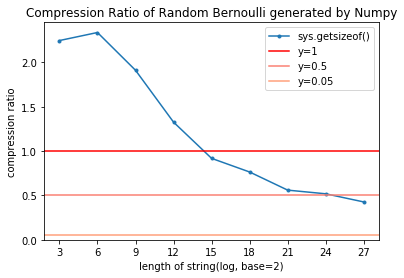

In [25]:
plt.plot(ratio_list_sys, marker='.', label="sys.getsizeof()")
# plt.plot(ratio_list_len, marker='.', label="len()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

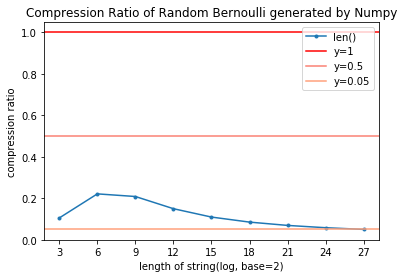

In [26]:
# plt.plot(ratio_list_sys, marker='.', label="sys.getsizeof()")
plt.plot(ratio_list_len, marker='.', label="len()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

In [ ]:
# ratio_list =[]
# edited_list =[]
# for size in np.logspace(3,27,9, base=2, dtype=int):
#     print("size: ", size)
#     uncompressed = random_generator(size)
#     uncompressed_size = len(uncompressed)
    
#     # original
#     compressed_original, comp_dict_original = compress_original(uncompressed)
#     compression_ratio = len(compressed_original)/uncompressed_size
#     ratio_list.append(compression_ratio)
#     print(compression_ratio)
    
# #     # edited
# #     compressed, comp_dict = compress_edit(uncompressed)
# #     compression_ratio = len(compressed)/uncompressed_size
# #     edited_list.append(compression_ratio)
# #     print(compression_ratio)
    
# #     decompressed, decomp_dict = decompress_edit(compressed)
# #     print(decompressed == uncompressed)
#     print()

In [ ]:
# plt.plot(ratio_list, marker='.', label="LZW compression ratio")
# # plt.plot(edited_list, marker='.', label="edited LZW compression ratio")

# plt.axhline(1, c="red", label="y=1")
# plt.axhline(0.5, c="salmon", label="y=0.5")
# plt.axhline(0.25, c="lightsalmon", label="y=0.25")

# plt.xticks(np.arange(10),np.linspace(3,30,10, dtype=int))
# plt.legend()
# plt.xlabel("length of string(log, base=2)")
# plt.ylabel("compression ratio")
# plt.ylim(0,)
# plt.title("Random Bernoulli generated by Numpy, len()")
# plt.show()

p:  1e-05
0.00018052328301819962
0.0625

p:  0.01725103448275862
0.12571436376337564
0.0859375

p:  0.03449206896551724
0.21644168870538089
0.09375

p:  0.05173310344827586
0.29371393154086173
0.123046875

p:  0.06897413793103448
0.3620836206189834
0.12109375

p:  0.0862151724137931
0.42370875846674133
0.13671875

p:  0.10345620689655172
0.47985673208415947
0.15234375

p:  0.12069724137931033
0.5313617488059681
0.162109375

p:  0.13793827586206897
0.5788137694795223
0.162109375

p:  0.1551793103448276
0.6226511765781215
0.16796875

p:  0.17242034482758622
0.6632116667999672
0.173828125

p:  0.18966137931034482
0.7007625539595875
0.189453125

p:  0.20690241379310345
0.7355199456064799
0.19140625

p:  0.22414344827586208
0.7676614705463314
0.19140625

p:  0.24138448275862068
0.7973350552663437
0.201171875

p:  0.25862551724137933
0.8246651681165573
0.2109375

p:  0.27586655172413793
0.8497573786036632
0.20703125

p:  0.29310758620689653
0.8727017593921329
0.212890625

p:  0.3103486206896

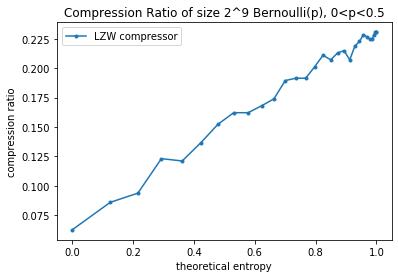

In [52]:
def entropy(p):
    return -p*log(p, 2) - (1-p)*log(1-p,2)
what = 9
size = 2 ** what

ratio_list =[]
edited_list =[]
true_entropy = []
for p in np.linspace(1e-5,0.5,30):
    print("p: ", p)
    true_entropy.append(entropy(p))
    print(entropy(p))
    
    uncompressed = uncompressed = random_generator(size, p)
    uncompressed_size = len(uncompressed)
    
    # original
#     compressed_original = compress(uncompressed)
#     compression_ratio = len(compressed_original)/uncompressed_size
#     ratio_list.append(compression_ratio)
#     print(compression_ratio)
    
    # edited
    compressed, comp_dict = compress_edit(uncompressed)
    compression_ratio = len(compressed)/uncompressed_size
    edited_list.append(compression_ratio)
    print(compression_ratio)
       
#     decompressed, decomp_dict = decompress_edit(compressed)
#     print(decompressed == uncompressed)
    print()
    
# plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
plt.plot(true_entropy, edited_list, marker='.', label = "LZW compressor")

plt.title("Compression Ratio of size 2^{} Bernoulli(p), 0<p<0.5".format(what))
plt.xlabel("theoretical entropy")
plt.ylabel("compression ratio")
plt.legend()
plt.show()

[0.16525658]
0.06652936284847392


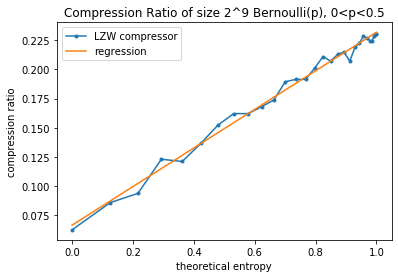

In [53]:
reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(edited_list[:]))
print(reg.coef_)
print(reg.intercept_)

plt.plot(true_entropy, edited_list, marker='.', label = "LZW compressor")
plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

plt.title("Compression Ratio of size 2^{} Bernoulli(p), 0<p<0.5".format(what))
plt.xlabel("theoretical entropy")
plt.ylabel("compression ratio")
plt.legend()
plt.show()

In [54]:
reg_inv = LinearRegression().fit(np.array(edited_list[:]).reshape(-1, 1), np.array(true_entropy[:]) )
print(reg_inv.coef_)
print(reg_inv.intercept_)

[5.99659908]
-0.3925123416663877


# Entropy Test for NBA data

In [218]:
def list_to_string(a):
    return re.sub('\W+','', str(a) )

def entropy(p):
    return -p*log(p, 2) - (1-p)*log(1-p,2)

def entropy_test(size):
    ratio_list = []
    true_entropy = []
    for p in np.linspace(1e-5,0.5,30):
#         print("p: ", p)
        true_entropy.append(entropy(p))

        uncompressed = random_generator(size, p)
        uncompressed_size = len(uncompressed)

        compressed, comp_dict = compress_edit(uncompressed)
        compression_ratio = len(compressed)/uncompressed_size
        ratio_list.append(compression_ratio)

    reg = LinearRegression().fit(np.array(true_entropy).reshape(-1, 1), np.array(ratio_list))
    reg_inv = LinearRegression().fit(np.array(ratio_list).reshape(-1, 1), np.array(true_entropy))

    plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

    plt.title("Compression Ratio of size {} Bernoulli(p), 0<p<0.5".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()
    return reg_inv

## test for several players

Stephen Curry
p =  0.5022522522522522
length =  444


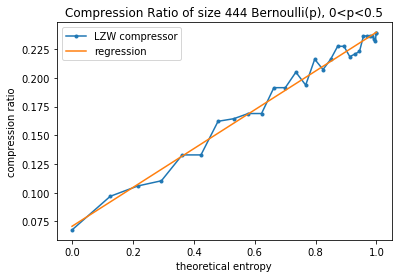

compression ratio:  0.22297297297297297
estimated entropy:  0.898017104668985
--------------------------

Kevin Durant
p =  0.4846153846153846
length =  390


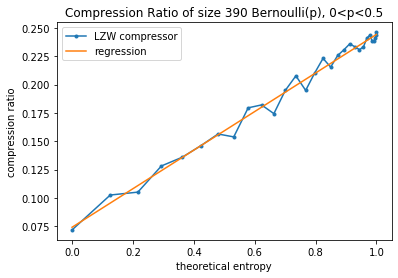

compression ratio:  0.23076923076923078
estimated entropy:  0.9185313855740965
--------------------------

LeBron James
p =  0.4746136865342163
length =  453


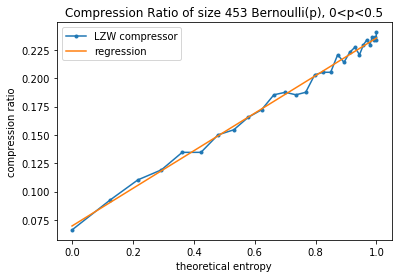

compression ratio:  0.22958057395143489
estimated entropy:  0.9624912804483382
--------------------------

Russell Westbrook
p =  0.49195402298850577
length =  435


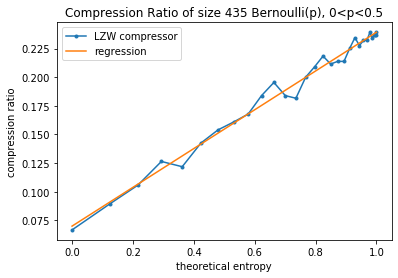

compression ratio:  0.22528735632183908
estimated entropy:  0.9151755122905664
--------------------------

James Harden
p =  0.47854077253218885
length =  466


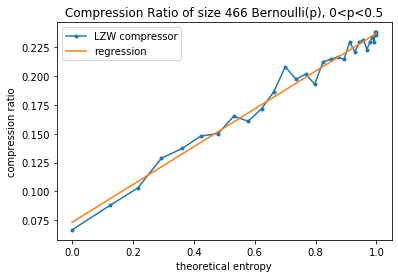

compression ratio:  0.22103004291845493
estimated entropy:  0.8981529302380217
--------------------------

Paul George
p =  0.47619047619047616
length =  399


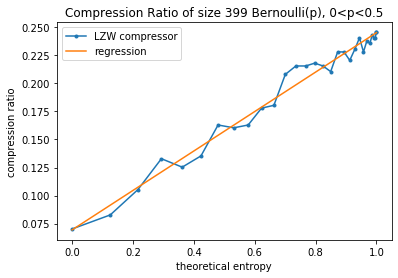

compression ratio:  0.23558897243107768
estimated entropy:  0.9403335561752572
--------------------------

Kyrie Irving
p =  0.46786632390745503
length =  389


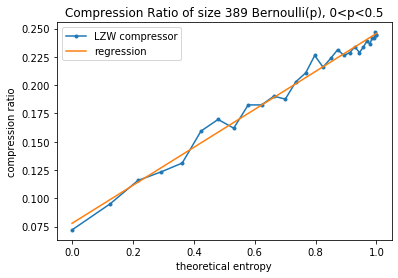

compression ratio:  0.2390745501285347
estimated entropy:  0.9571554908255543
--------------------------

Chris Paul
p =  0.47044334975369456
length =  406


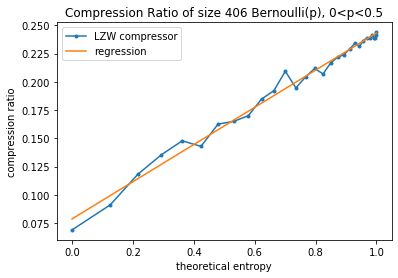

compression ratio:  0.2315270935960591
estimated entropy:  0.926482178389917
--------------------------



In [162]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
quality = 9 # best but slow
span = 3
#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = get_delta(player_data)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed, comp_dict = compress_edit(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)
    
    reg_inv = entropy_test(size)
    ent = reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("--------------------------")
    print()

## test for a fixed player, for different alpha

Stephen Curry
alpha:  0.1


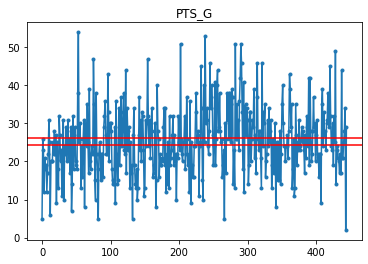

p =  0.9056179775280899
length =  445


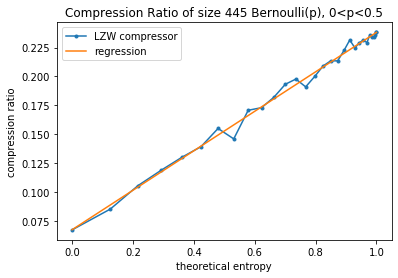

compression ratio:  0.14831460674157304
estimated entropy:  0.475279065999897
--------------------------

alpha:  0.2


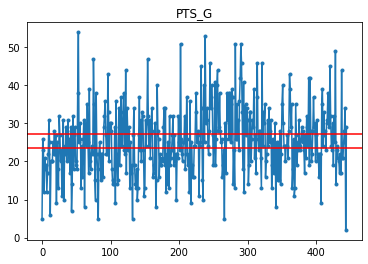

p =  0.8134831460674158
length =  445


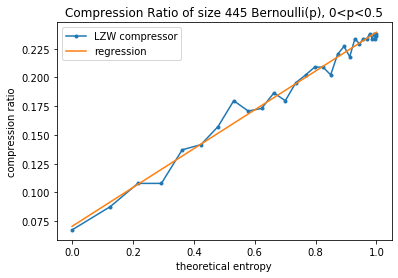

compression ratio:  0.18876404494382024
estimated entropy:  0.7008276662758043
--------------------------

alpha:  0.30000000000000004


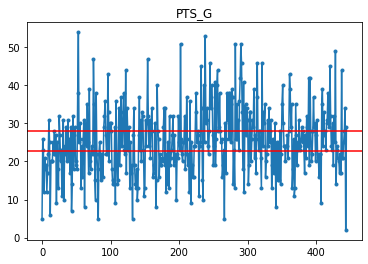

p =  0.7235955056179775
length =  445


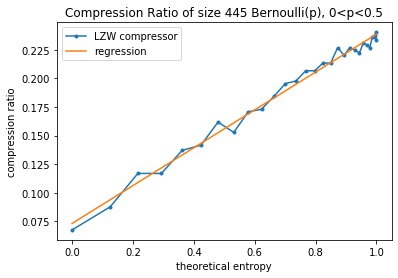

compression ratio:  0.21123595505617979
estimated entropy:  0.8329285761633242
--------------------------

alpha:  0.4


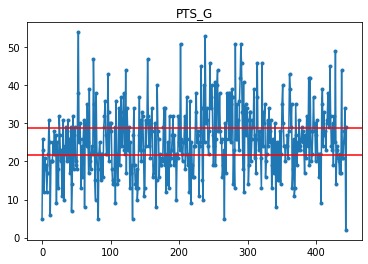

p =  0.651685393258427
length =  445


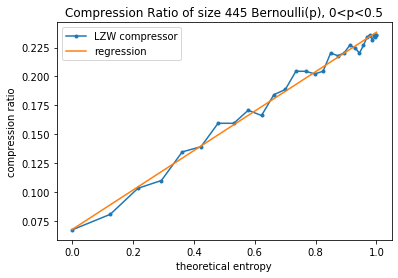

compression ratio:  0.2247191011235955
estimated entropy:  0.918651203457551
--------------------------

alpha:  0.5


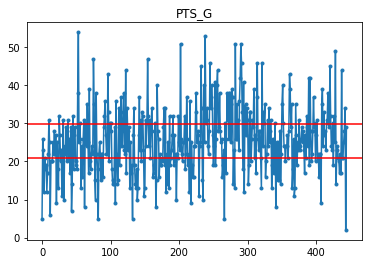

p =  0.5842696629213483
length =  445


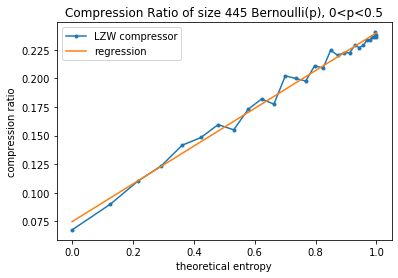

compression ratio:  0.23595505617977527
estimated entropy:  0.9730899307562607
--------------------------

alpha:  0.6


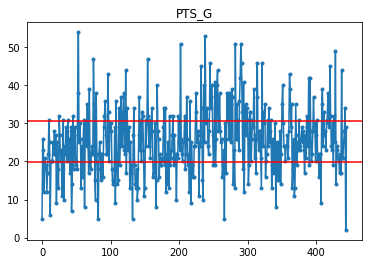

p =  0.5123595505617977
length =  445


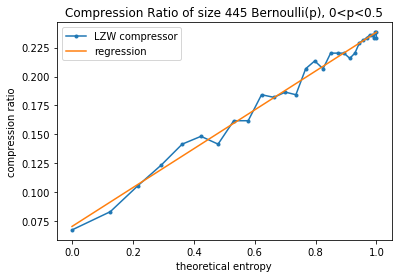

compression ratio:  0.24044943820224718
estimated entropy:  1.009028785308299
--------------------------

alpha:  0.7000000000000001


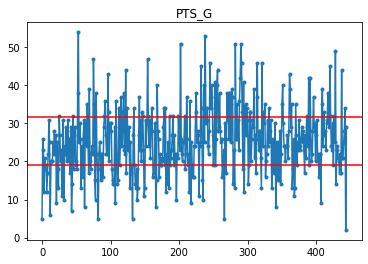

p =  0.47415730337078654
length =  445


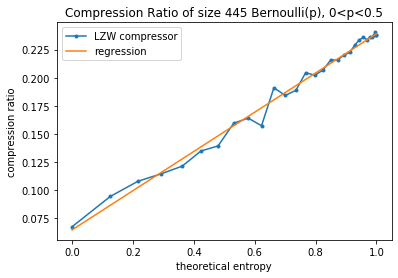

compression ratio:  0.23595505617977527
estimated entropy:  0.979620428182734
--------------------------

alpha:  0.8


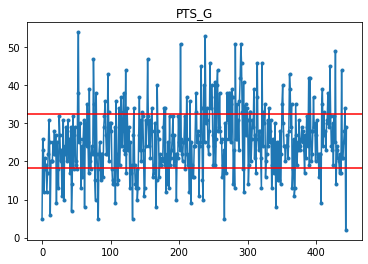

p =  0.3955056179775281
length =  445


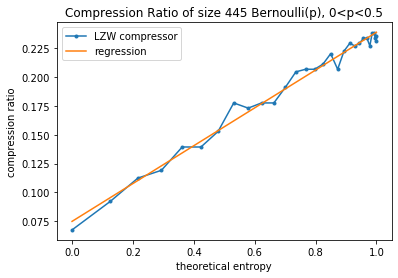

compression ratio:  0.23146067415730337
estimated entropy:  0.9518111258005287
--------------------------

alpha:  0.9


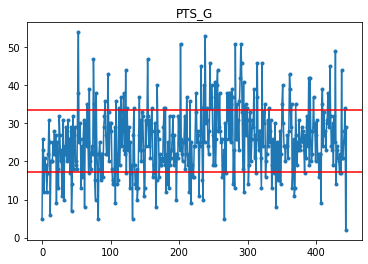

p =  0.350561797752809
length =  445


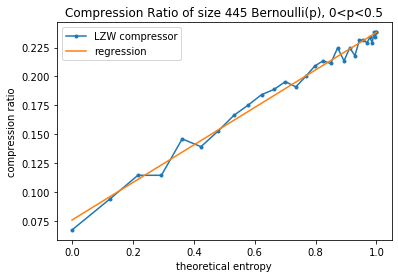

compression ratio:  0.2292134831460674
estimated entropy:  0.942569964045158
--------------------------



In [219]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
player_name = player_list_1[0]
print(player_name)
#############
for alpha in np.linspace(0.1,0.9,9):
    print("alpha: ", alpha)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = ep_error(player_data, alpha, True)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed, comp_dict = compress_edit(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)
    
    reg_inv = entropy_test(size)
    ent = reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("--------------------------")
    print()

In [217]:
entropy(0.4)

0.9709505944546686

## residual error test

In [184]:
def ep_error(player_data, alpha, graph=False):
    # 1 if outside m +- alpha*sd
    # 0 if within m +- alpha*sd
    m = player_data.mean()
    sd = player_data.std()
    binary = copy.deepcopy(player_data)

    if graph:
        plt.title(player_data.name)
        plt.plot(player_data, marker='.')
        plt.axhline(m+alpha*sd, color='r')
        plt.axhline(m-alpha*sd, color='r')
        plt.show()


    binary[(player_data > m+alpha*sd) | (player_data < m-alpha*sd)] = 1
    binary[(player_data < m+alpha*sd) & (player_data > m-alpha*sd) ] = 0
    return list(binary)

In [185]:
def get_binary(data):
    binary = copy.deepcopy(data)
    binary[data >= 0] = 1
    binary[data < 0] = 0
    return binary

Stephen Curry


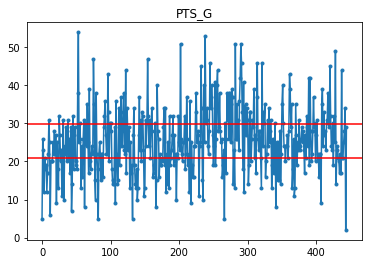

p =  0.5842696629213483
length =  445


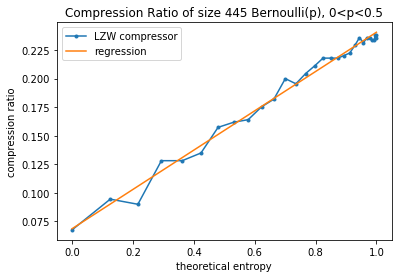

compression ratio:  0.23595505617977527
estimated entropy:  0.9697945388561772
--------------------------

Kevin Durant


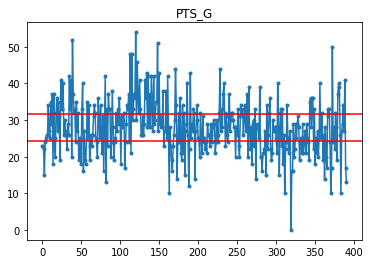

p =  0.618925831202046
length =  391


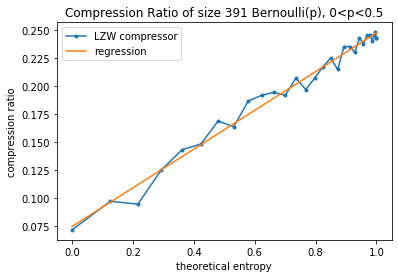

compression ratio:  0.23529411764705882
estimated entropy:  0.9258392110402939
--------------------------

LeBron James


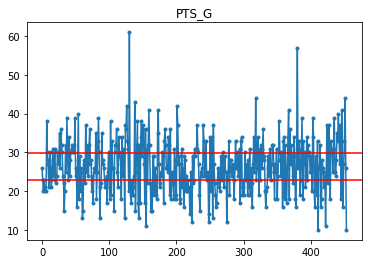

p =  0.6101321585903083
length =  454


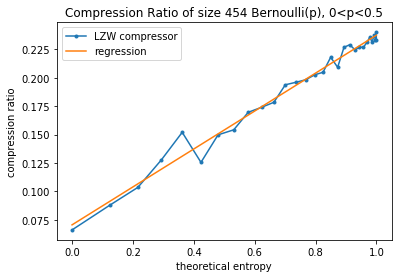

compression ratio:  0.23127753303964757
estimated entropy:  0.958685964527154
--------------------------

Russell Westbrook


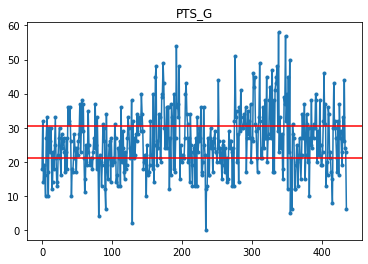

p =  0.6169724770642202
length =  436


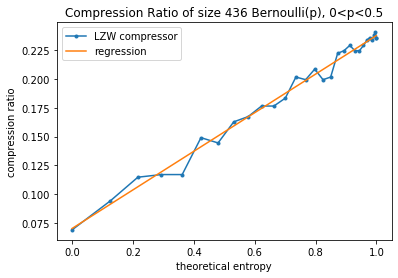

compression ratio:  0.22935779816513763
estimated entropy:  0.9459331707507809
--------------------------

James Harden


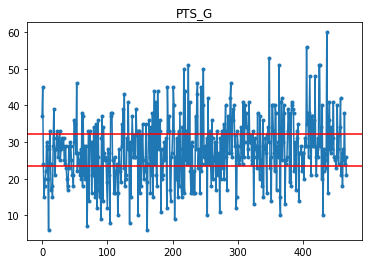

p =  0.5845824411134903
length =  467


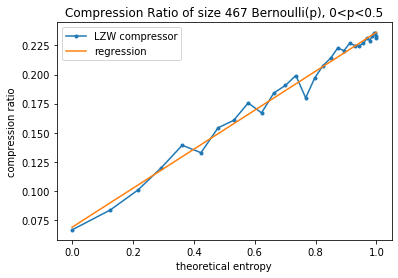

compression ratio:  0.2334047109207709
estimated entropy:  0.9787400469468227
--------------------------

Paul George


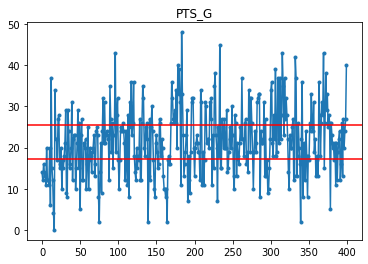

p =  0.62
length =  400


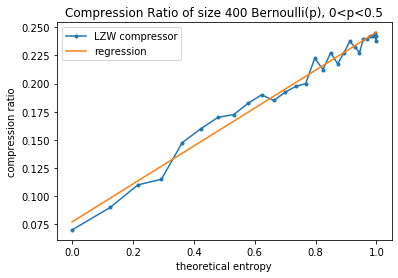

compression ratio:  0.235
estimated entropy:  0.9328476387315153
--------------------------

Kyrie Irving


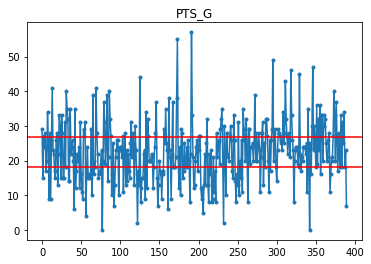

p =  0.6282051282051282
length =  390


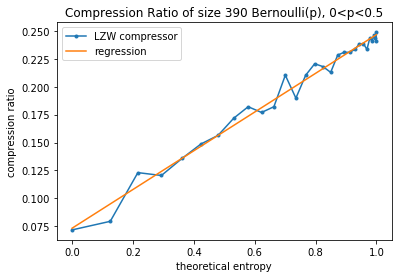

compression ratio:  0.2358974358974359
estimated entropy:  0.934604623865598
--------------------------

Chris Paul


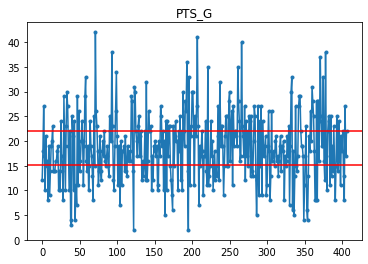

p =  0.6142506142506142
length =  407


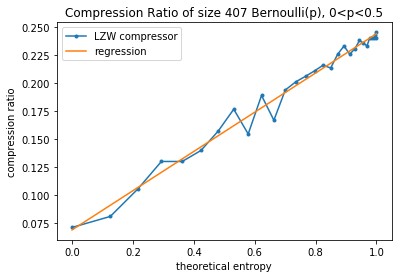

compression ratio:  0.23832923832923833
estimated entropy:  0.9612665308599809
--------------------------



In [179]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
alpha = 0.5
#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = ep_error(player_data, alpha, True)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed, comp_dict = compress_edit(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)
    
    reg_inv = entropy_test(size)
    ent = reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("--------------------------")
    print()

Stephen Curry


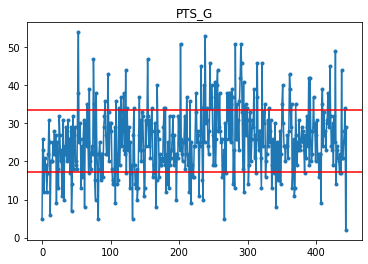

p =  0.350561797752809
length =  445


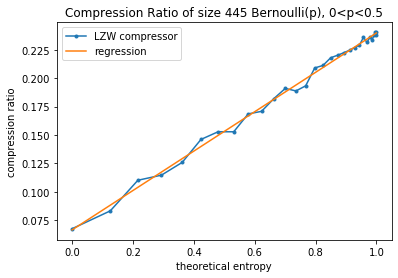

compression ratio:  0.2292134831460674
estimated entropy:  0.9378799366214624


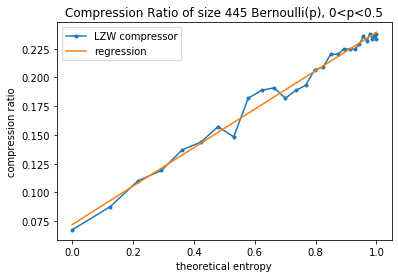

compression ratio:  0.24044943820224718
estimated entropy:  1.0025692502942483
--------------------------

Kevin Durant


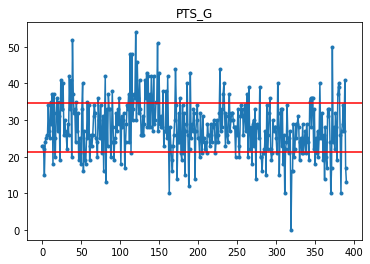

p =  0.35805626598465473
length =  391


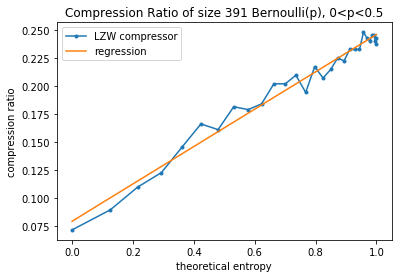

compression ratio:  0.23529411764705882
estimated entropy:  0.9303359367579279


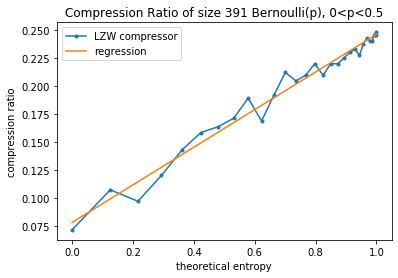

compression ratio:  0.24808184143222506
estimated entropy:  1.0049335708100302
--------------------------

LeBron James


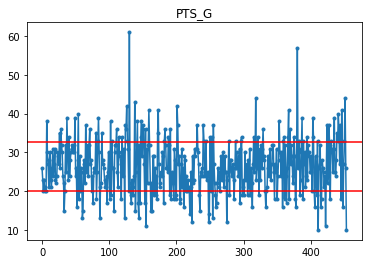

p =  0.3876651982378855
length =  454


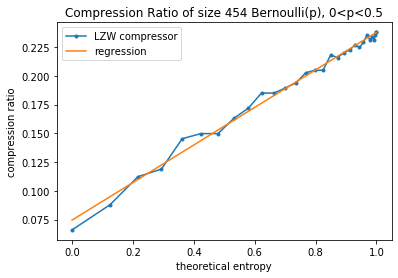

compression ratio:  0.23127753303964757
estimated entropy:  0.9579743513282141


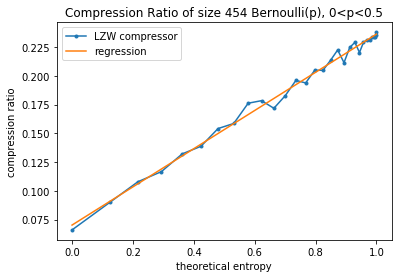

compression ratio:  0.2356828193832599
estimated entropy:  0.9945079615986882
--------------------------

Russell Westbrook


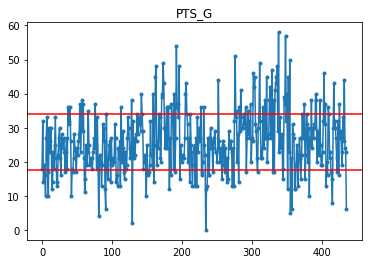

p =  0.3440366972477064
length =  436


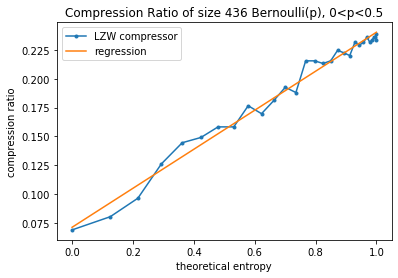

compression ratio:  0.22706422018348624
estimated entropy:  0.9175745926232878


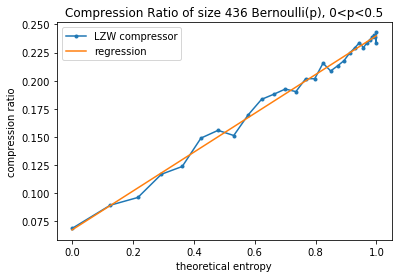

compression ratio:  0.23853211009174313
estimated entropy:  0.9889366334276474
--------------------------

James Harden


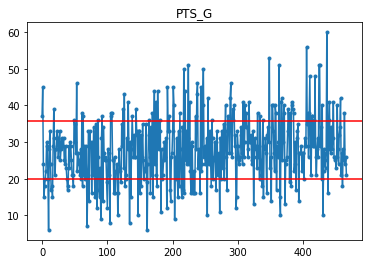

p =  0.3533190578158458
length =  467


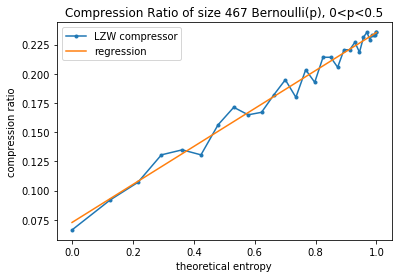

compression ratio:  0.22269807280513917
estimated entropy:  0.9189183000739022


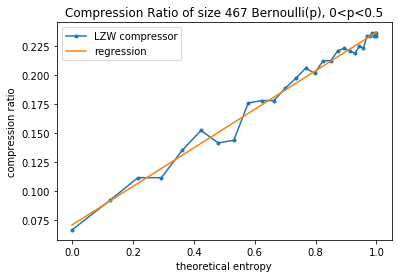

compression ratio:  0.23554603854389722
estimated entropy:  0.9900770598422334
--------------------------

Paul George


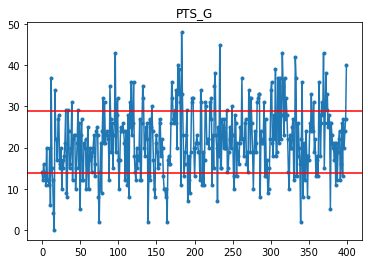

p =  0.375
length =  400


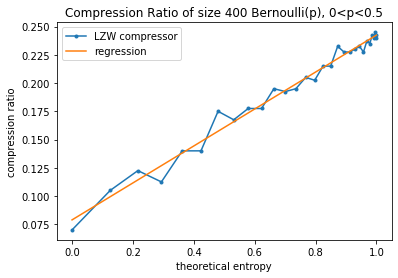

compression ratio:  0.2375
estimated entropy:  0.9652404915659573


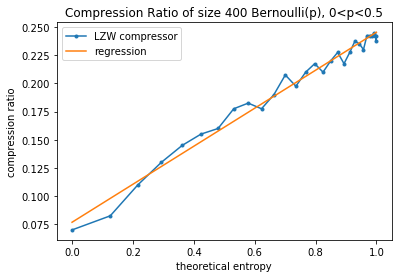

compression ratio:  0.245
estimated entropy:  0.9929504124535061
--------------------------

Kyrie Irving


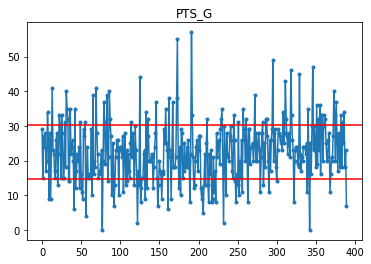

p =  0.3384615384615385
length =  390


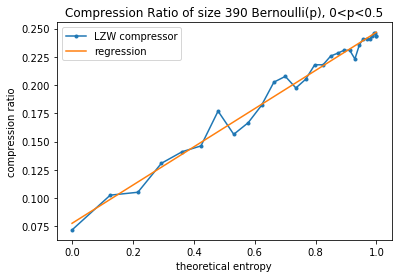

compression ratio:  0.2358974358974359
estimated entropy:  0.9319454588383739


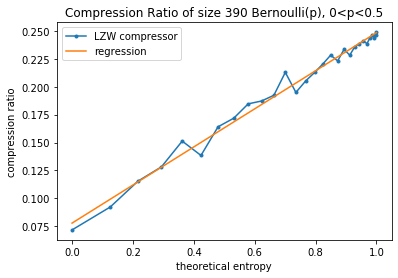

compression ratio:  0.24358974358974358
estimated entropy:  0.9688954595658429
--------------------------

Chris Paul


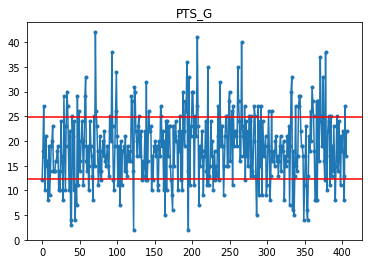

p =  0.3857493857493858
length =  407


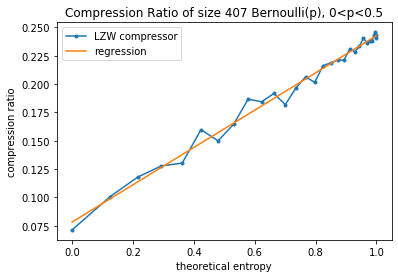

compression ratio:  0.23587223587223588
estimated entropy:  0.9552670684462475


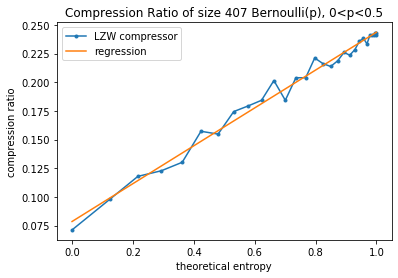

compression ratio:  0.23832923832923833
estimated entropy:  0.9647216504632411
--------------------------



In [216]:
metric = "PTS_G"
span = 10

#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = ep_error(player_data, alpha, True)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed, comp_dict = compress_edit(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)
    
    reg_inv = entropy_test(size)
    ent = reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    
    player_stat = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
#     player_stat_ewma = player_stat.ewm(span=span).mean()
    player_stat_ewma = run_ewma(player_stat, span)
    player_stat_ewma = pd.Series(player_stat_ewma, name=player_name)
    player_residual = (player_stat - player_stat_ewma)
    
    L = int(np.floor(np.sqrt(len(player_stat.to_list())/10)))
   
    # residual test
    res_binary = get_binary(player_residual)
    res_binary = list_to_string(res_binary.values.astype(int))
    size = len(res_binary)
    compressed, comp_dict = compress_edit(res_binary)
    compression_ratio = len(compressed)/size
    
    reg_inv = entropy_test(size)
    ent = reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("--------------------------")
    print()

In [211]:
a = res_binary
re.sub('\W+','', str(a) )

'1110111011110111111110100110101101110110101001011000110100001101101001000101100100011101101111001101110000101000101110110010100100000110000001111011000111110101100001001110000001101000101001110100011110100000100100001010001111011011110010101100011110001001100100000001011110110110001010101111001011010001100111000110000001011100010101100100100101010111100000101110100100110101001101001011010100011110010000001101010111101000101010000000010011101'

In [212]:
list_to_string(a)

'1110111011110111111110100110101101110110101001011000110100001101101001000101100100011101101111001101110000101000101110110010100100000110000001111011000111110101100001001110000001101000101001110100011110100000100100001010001111011011110010101100011110001001100100000001011110110110001010101111001011010001100111000110000001011100010101100100100101010111100000101110100100110101001101001011010100011110010000001101010111101000101010000000010011101'

In [199]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
quality = 9 # best but slow
span = 3
#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = get_delta(player_data)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    print("p = ", p)
    print("length = ", len(player_delta))
    print()

    print("* original - X(t) list")
    modified_lzw_test(player_delta)
    print()

    print("* 111110000 list")
    ones = np.ones(int(p*len(player_delta)))
    zeros = np.zeros(len(player_delta) - len(ones))
    easy_delta = np.concatenate([ones, zeros]).astype(int)
    modified_lzw_test(list(easy_delta))
    print()

    print("* random list")
    hard_delta = bernoulli.rvs(p, size=len(player_delta))
    modified_lzw_test(list(hard_delta))
    print()
    
    print("------------------------")

Stephen Curry
p =  0.5022522522522522
length =  444

* original - X(t) list
- using lzw
ratio           :  1.8498985801217038
no loss?        :  True

* 111110000 list
- using lzw
ratio           :  0.8762677484787018
no loss?        :  True

* random list
- using lzw
ratio           :  1.8498985801217038
no loss?        :  True

------------------------
Kevin Durant
p =  0.4846153846153846
length =  390

* original - X(t) list
- using lzw
ratio           :  2.0774487471526197
no loss?        :  True

* 111110000 list
- using lzw
ratio           :  0.9840546697038725
no loss?        :  True

* random list
- using lzw
ratio           :  2.0774487471526197
no loss?        :  True

------------------------
LeBron James
p =  0.4746136865342163
length =  453

* original - X(t) list
- using lzw
ratio           :  1.8167330677290836
no loss?        :  True

* 111110000 list
- using lzw
ratio           :  0.8605577689243028
no loss?        :  True

* random list
- using lzw
ratio           :  

# modify modify lzw

In [90]:
def compress_edit2(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 2
    dictionary = {'0': 0, '1': 1}
    w = ""
    result = []
    i=1
    for c in uncompressed:
        i+=1
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            if (len(dictionary) < 256):
                dictionary[wc] = dict_size
                dict_size += 1
                w = c
    if w:
        result.append(dictionary[w])

    return result, dictionary

def decompress_edit2(compressed):
    """Decompress a list of output ks to a string."""
    # Build the dictionary.
    dict_size = 2
    dictionary = {0: '0', 1: '1'}
    # in Python 3: dictionary = {i: chr(i) for i in range(dict_size)}
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    
    w = dictionary[compressed[0]]
    compressed = compressed[1:]
    result = ""
    result += w
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result += entry
        
        # Add w+entry[0] to the dictionary.
        if (len(dictionary) < 256):
            dictionary[dict_size] = w + entry[0]
            dict_size += 1
            w = entry
    return result, dictionary

In [115]:
uncompressed = random_generator(2**10, 0.5)
com, dic = compress_edit2(uncompressed)

In [116]:
decom, dic2 = decompress_edit2(com)

In [117]:
decom == uncompressed

True

In [113]:
len(uncompressed)

4096

In [114]:
len(decom)

20536

In [220]:
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
        if val == value: 
            return key 
  
    return "key doesn't exist"

In [68]:
len(uncompressed.encode('utf-8'))

100

In [66]:
size = 100
space = 50
numrand = np.random.randn(size*space)
numrand[numrand>0] = 1
numrand[numrand<0] = 0
spaced = numrand[0::space]
a = list(spaced.astype(int))
uncompressed = re.sub('\W+','', str(a) )
uncompressed

'1100000011100010110110010100110110000111110100011110010101010111111001011100111100001111100011111100'

In [48]:
"""Compress a string to a list of output symbols."""

# Build the dictionary.
dict_size = 256
dictionary = {chr(i): i for i in range(dict_size)}
print("original dict")
print(dictionary)
w = ""
result = []
for c in uncompressed:
    wc = w + c
    if wc in dictionary:
        w = wc
    else:
        result.append(dictionary[w])
        # Add wc to the dictionary.
        dictionary[wc] = dict_size
        dict_size += 1
        w = c

# Output the code for w.
if w:
    result.append(dictionary[w])

original dict
{'\x00': 0, '\x01': 1, '\x02': 2, '\x03': 3, '\x04': 4, '\x05': 5, '\x06': 6, '\x07': 7, '\x08': 8, '\t': 9, '\n': 10, '\x0b': 11, '\x0c': 12, '\r': 13, '\x0e': 14, '\x0f': 15, '\x10': 16, '\x11': 17, '\x12': 18, '\x13': 19, '\x14': 20, '\x15': 21, '\x16': 22, '\x17': 23, '\x18': 24, '\x19': 25, '\x1a': 26, '\x1b': 27, '\x1c': 28, '\x1d': 29, '\x1e': 30, '\x1f': 31, ' ': 32, '!': 33, '"': 34, '#': 35, '$': 36, '%': 37, '&': 38, "'": 39, '(': 40, ')': 41, '*': 42, '+': 43, ',': 44, '-': 45, '.': 46, '/': 47, '0': 48, '1': 49, '2': 50, '3': 51, '4': 52, '5': 53, '6': 54, '7': 55, '8': 56, '9': 57, ':': 58, ';': 59, '<': 60, '=': 61, '>': 62, '?': 63, '@': 64, 'A': 65, 'B': 66, 'C': 67, 'D': 68, 'E': 69, 'F': 70, 'G': 71, 'H': 72, 'I': 73, 'J': 74, 'K': 75, 'L': 76, 'M': 77, 'N': 78, 'O': 79, 'P': 80, 'Q': 81, 'R': 82, 'S': 83, 'T': 84, 'U': 85, 'V': 86, 'W': 87, 'X': 88, 'Y': 89, 'Z': 90, '[': 91, '\\': 92, ']': 93, '^': 94, '_': 95, '`': 96, 'a': 97, 'b': 98, 'c': 99, 'd':

In [49]:
result

[48,
 48,
 49,
 256,
 258,
 49,
 260,
 259,
 257,
 258,
 257,
 259,
 265,
 267,
 264,
 261,
 264,
 270,
 272,
 261,
 268,
 266,
 274,
 256,
 273,
 275,
 276,
 281,
 279,
 267,
 275,
 274,
 286,
 258]

In [53]:
bin(49)

'0b110001'

In [44]:
dictionary

{'\x00': 0,
 '\x01': 1,
 '\x02': 2,
 '\x03': 3,
 '\x04': 4,
 '\x05': 5,
 '\x06': 6,
 '\x07': 7,
 '\x08': 8,
 '\t': 9,
 '\n': 10,
 '\x0b': 11,
 '\x0c': 12,
 '\r': 13,
 '\x0e': 14,
 '\x0f': 15,
 '\x10': 16,
 '\x11': 17,
 '\x12': 18,
 '\x13': 19,
 '\x14': 20,
 '\x15': 21,
 '\x16': 22,
 '\x17': 23,
 '\x18': 24,
 '\x19': 25,
 '\x1a': 26,
 '\x1b': 27,
 '\x1c': 28,
 '\x1d': 29,
 '\x1e': 30,
 '\x1f': 31,
 ' ': 32,
 '!': 33,
 '"': 34,
 '#': 35,
 '$': 36,
 '%': 37,
 '&': 38,
 "'": 39,
 '(': 40,
 ')': 41,
 '*': 42,
 '+': 43,
 ',': 44,
 '-': 45,
 '.': 46,
 '/': 47,
 '0': 48,
 '1': 49,
 '2': 50,
 '3': 51,
 '4': 52,
 '5': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57,
 ':': 58,
 ';': 59,
 '<': 60,
 '=': 61,
 '>': 62,
 '?': 63,
 '@': 64,
 'A': 65,
 'B': 66,
 'C': 67,
 'D': 68,
 'E': 69,
 'F': 70,
 'G': 71,
 'H': 72,
 'I': 73,
 'J': 74,
 'K': 75,
 'L': 76,
 'M': 77,
 'N': 78,
 'O': 79,
 'P': 80,
 'Q': 81,
 'R': 82,
 'S': 83,
 'T': 84,
 'U': 85,
 'V': 86,
 'W': 87,
 'X': 88,
 'Y': 89,
 'Z': 90,
 '[': 91,


In [32]:
# Shannon Entropy of a string
# = minimum average number of bits per symbol
# required for encoding the string
#
# So the theoretical limit for data compression:
# Shannon Entropy of the string * string length
# FB - 201011291

st = a_str # Shannon entropy for this would be 1 bit/symbol

stList = list(st)
alphabet = list(set(stList)) # list of symbols in the string
print('Alphabet of symbols in the string:')
print(alphabet)

# calculate the frequency of each symbol in the string
freqList = []
for symbol in alphabet:
    ctr = 0
    for sym in stList:
        if sym == symbol:
            ctr += 1
    freqList.append(float(ctr) / len(stList))
print('Frequencies of alphabet symbols:')
print(freqList)

# Shannon entropy
ent = 0.0
for freq in freqList:
    ent = ent + freq * math.log(freq, 2)
ent = -ent
print('Shannon entropy:')
print(ent)
print('Minimum number of bits required to encode each symbol:')
print(int(math.ceil(ent)))

Alphabet of symbols in the string:
['1', '0']
Frequencies of alphabet symbols:
[0.52, 0.48]
Shannon entropy:
0.9988455359952018
Minimum number of bits required to encode each symbol:
1


In [1065]:
p = 0.04
-p*log(p, 2)-(1-p)*log(1-p, 2)

0.24229218908241482

# 1. PAGE matrix test + EWMA Prediction

In [643]:
def run_ewma(vals, window=3):
    # take EWMA in both directions with a smaller span term
    fwd = pd.DataFrame(vals).ewm(span=window).mean().values.flatten() # take EWMA in fwd direction
    bwd = pd.DataFrame(vals[::-1]).ewm(span=window).mean().values.flatten() # take EWMA in bwd direction
    runs_smoothed = 0.7 * fwd + 0.3 * bwd[::-1]
#     return runs_smoothed
    return fwd
#     return bwd[::-1]


------------------------------------------------------------------


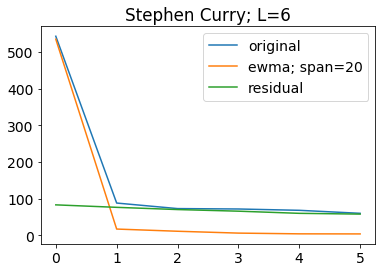

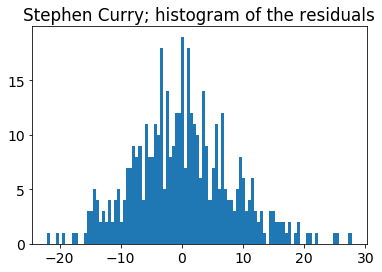

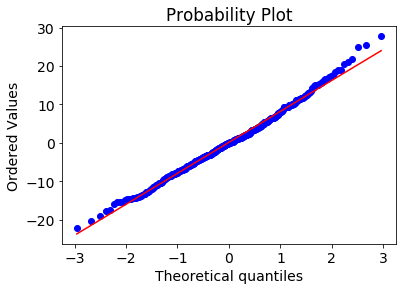

L:  6


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


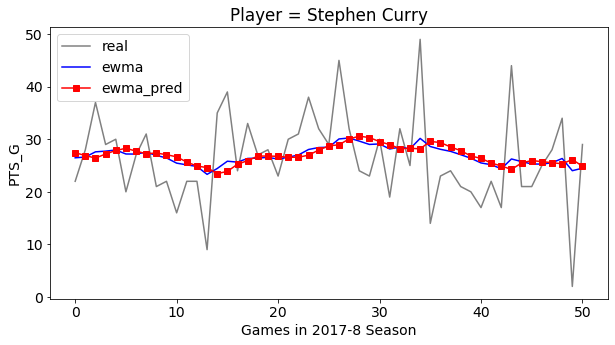

Stephen Curry
*** RMSE compared to ewma ***
first 0-5 games:  0.7378655774732923
first 5-10 games:  0.657102790746046
first 10-20 games:  0.9274819233966413
all           :  0.8822938893391942

Stephen Curry
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.5069337607048426
first 5-10 games:  0.5126337528365547
first 10-20 games:  0.8466935292936296
all           :  0.8313656673743596
Stephen Curry
*** RMSE compared to actual***
first 0-5 games:  5.487126646307852
first 5-10 games:  5.467824758152748
first 10-20 games:  8.907747257543937
all           :  8.710207207044254
Stephen Curry
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  6.099180272790763
first 5-10 games:  7.293833011524188
first 10-20 games:  11.29601699715435
all           :  12.366146070116226

------------------------------------------------------------------


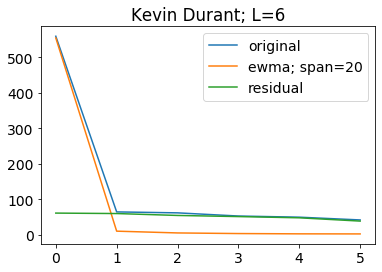

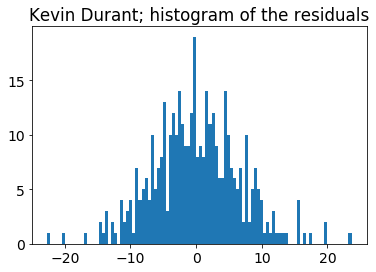

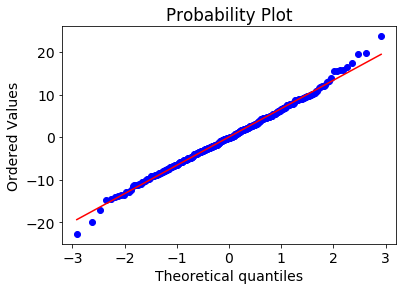

L:  5


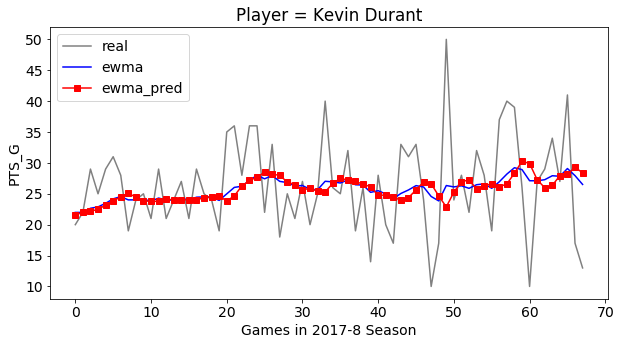

Kevin Durant
*** RMSE compared to ewma ***
first 0-5 games:  0.368192422845687
first 5-10 games:  0.5587447232219594
first 10-20 games:  0.3286166258391932
all           :  0.9692785825229708

Kevin Durant
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.41947688831533814
first 5-10 games:  0.4325547547284945
first 10-20 games:  0.3338886672695498
all           :  0.7503225866631654
Kevin Durant
*** RMSE compared to actual***
first 0-5 games:  4.241763645239199
first 5-10 games:  4.525228314864965
first 10-20 games:  3.470873184193577
all           :  7.986150329451944
Kevin Durant
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  5.761944116355173
first 5-10 games:  4.898979485566356
first 10-20 games:  5.513619500836088
all           :  10.369638940903675

------------------------------------------------------------------


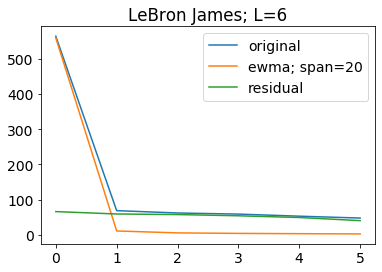

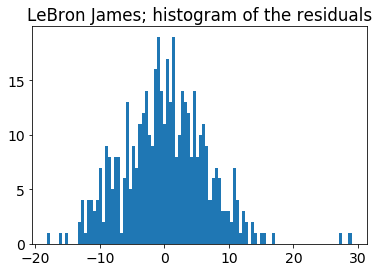

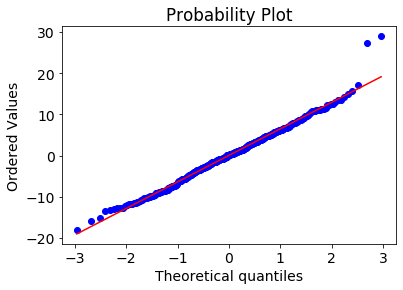

L:  6


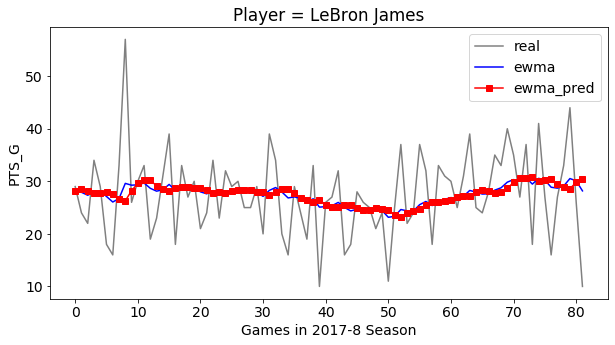

LeBron James
*** RMSE compared to ewma ***
first 0-5 games:  0.5431297601356756
first 5-10 games:  1.746733166741702
first 10-20 games:  0.7577454558579548
all           :  0.8633925081184027

LeBron James
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.4247722474935527
first 5-10 games:  1.477392660194498
first 10-20 games:  0.6302573780533554
all           :  0.7735319231879819
LeBron James
*** RMSE compared to actual***
first 0-5 games:  4.5092621532147765
first 5-10 games:  15.63873994969759
first 10-20 games:  6.584915702248456
all           :  8.119780528857055
LeBron James
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  6.434283176858165
first 5-10 games:  19.75348070594142
first 10-20 games:  10.373041983911952
all           :  11.056396449070755

------------------------------------------------------------------


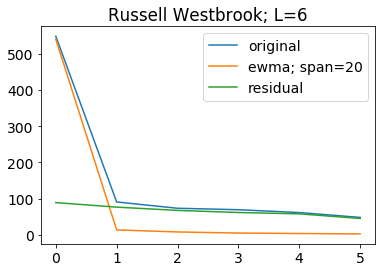

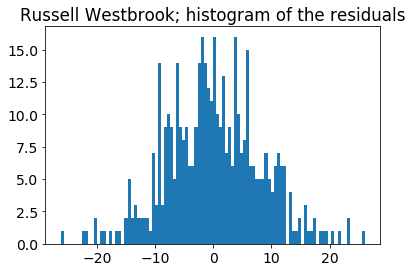

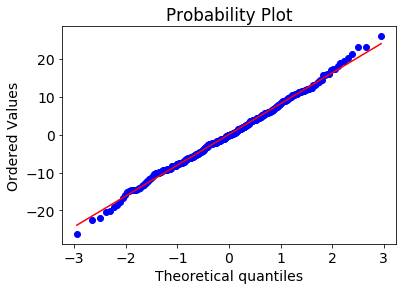

L:  5


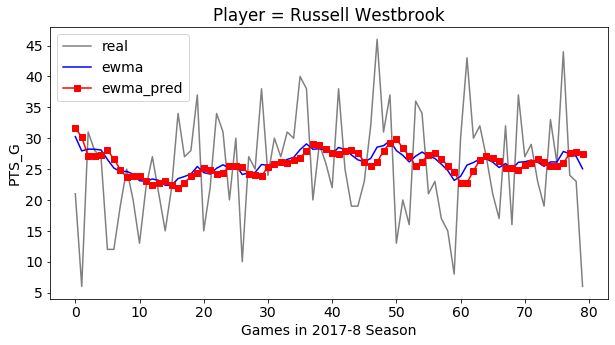

Russell Westbrook
*** RMSE compared to ewma ***
first 0-5 games:  1.4353172964002447
first 5-10 games:  1.0487511024090486
first 10-20 games:  0.8129008843196796
all           :  1.0593424386857977

Russell Westbrook
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  1.1298119996940321
first 5-10 games:  0.9813892495512241
first 10-20 games:  0.7028393347636167
all           :  0.8714518031232653
Russell Westbrook
*** RMSE compared to actual***
first 0-5 games:  11.961808352106495
first 5-10 games:  10.233377069754253
first 10-20 games:  7.407484032436631
all           :  9.25097788425794
Russell Westbrook
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  14.939879517586478
first 5-10 games:  8.18535277187245
first 10-20 games:  7.422937423958254
all           :  11.25

------------------------------------------------------------------


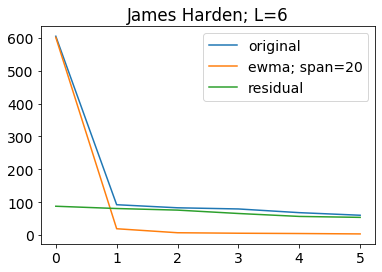

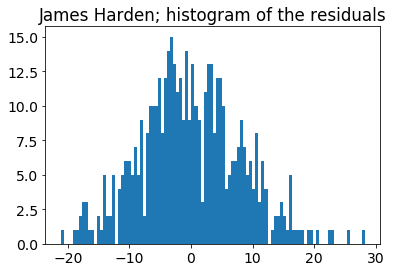

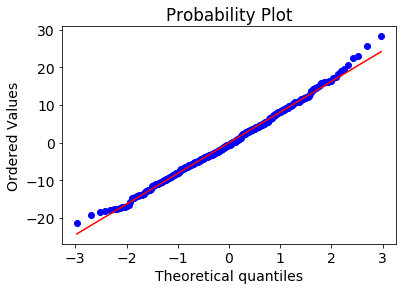

L:  6


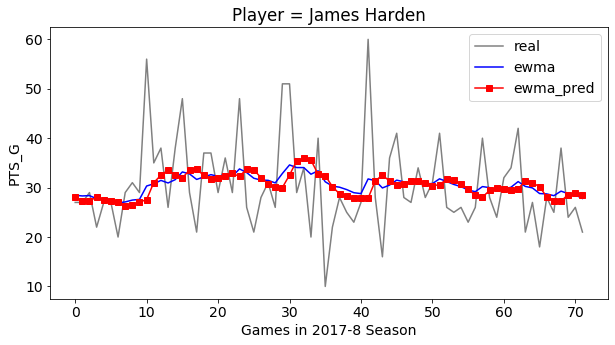

James Harden
*** RMSE compared to ewma ***
first 0-5 games:  0.6642906076717904
first 5-10 games:  0.6293833223998584
first 10-20 games:  1.5346053870645162
all           :  1.2613529542389332

James Harden
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.29029038053601386
first 5-10 games:  0.38242807921793887
first 10-20 games:  1.1412064170772696
all           :  0.8902012834738176
James Harden
*** RMSE compared to actual***
first 0-5 games:  2.846745166672805
first 5-10 games:  4.027198933469928
first 10-20 games:  11.95289194463428
all           :  9.423974240510335
James Harden
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  3.9496835316262997
first 5-10 games:  5.253570214625479
first 10-20 games:  14.99333185119305
all           :  12.504443654601795

------------------------------------------------------------------


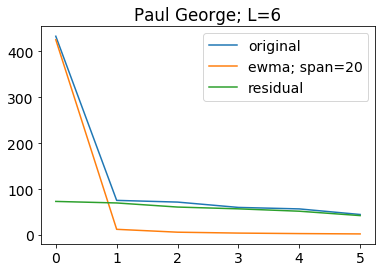

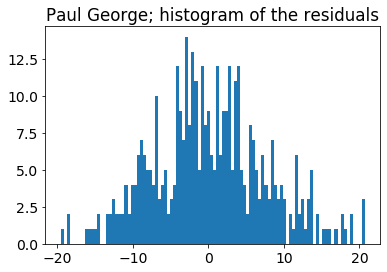

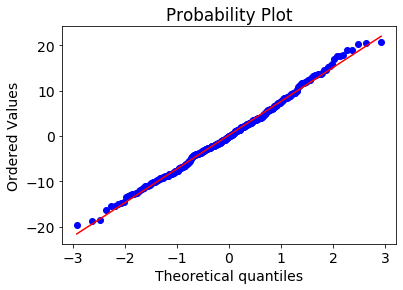

L:  5


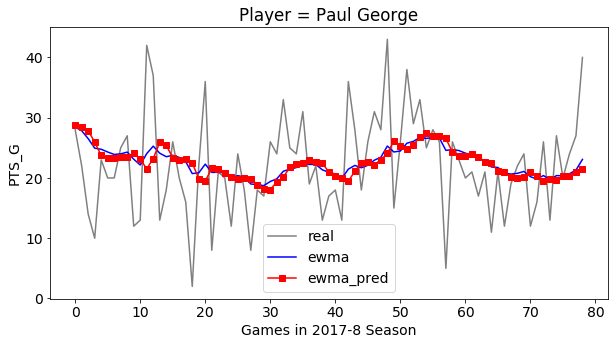

Paul George
*** RMSE compared to ewma ***
first 0-5 games:  0.9445677849620302
first 5-10 games:  0.8012612886590539
first 10-20 games:  1.5130587685005052
all           :  0.9636667614404022

Paul George
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.9618778176159067
first 5-10 games:  0.6059556292766868
first 10-20 games:  1.1095564606873094
all           :  0.8253876638772132
Paul George
*** RMSE compared to actual***
first 0-5 games:  9.899413994987157
first 5-10 games:  6.060282864564022
first 10-20 games:  11.931422088090342
all           :  8.619617353449677
Paul George
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  7.758865896508329
first 5-10 games:  7.252585745787498
first 10-20 games:  14.7648230602334
all           :  10.83711391352345

------------------------------------------------------------------


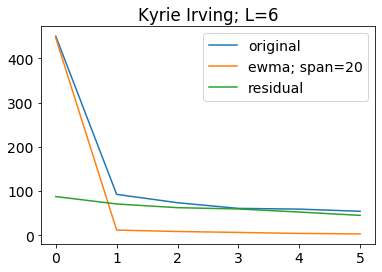

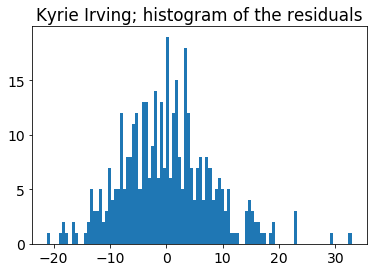

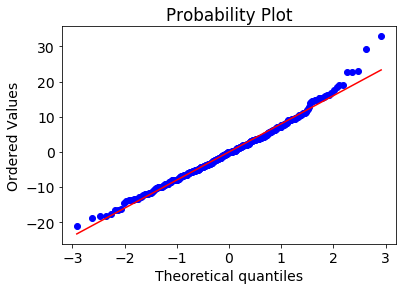

L:  5


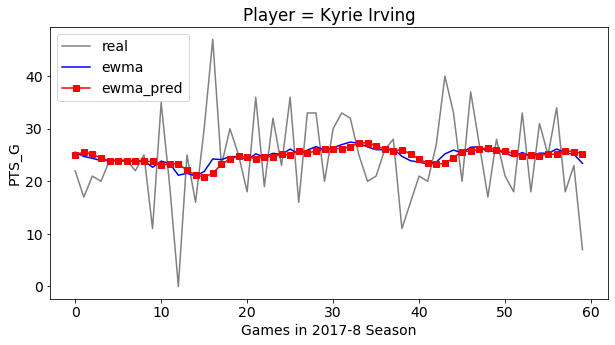

Kyrie Irving
*** RMSE compared to ewma ***
first 0-5 games:  0.6133682566970918
first 5-10 games:  0.5100094138046914
first 10-20 games:  1.237990878404288
all           :  0.8343482857454677

Kyrie Irving
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.46886234037100233
first 5-10 games:  0.5580097463001243
first 10-20 games:  1.1730556242976566
all           :  0.8070123290983602
Kyrie Irving
*** RMSE compared to actual***
first 0-5 games:  4.880686060321439
first 5-10 games:  5.805047470705537
first 10-20 games:  12.28539057558247
all           :  8.437000082524309
Kyrie Irving
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  10.83512805646523
first 5-10 games:  6.465291950097845
first 10-20 games:  17.418381095842403
all           :  12.041594578792296

------------------------------------------------------------------


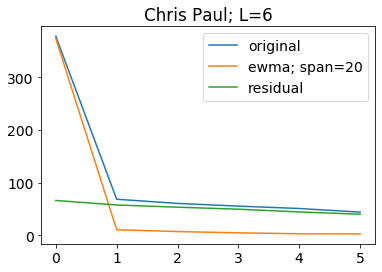

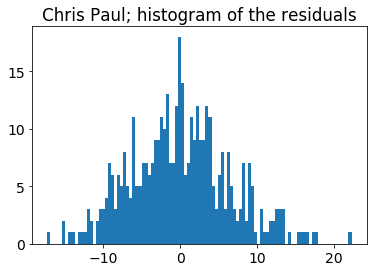

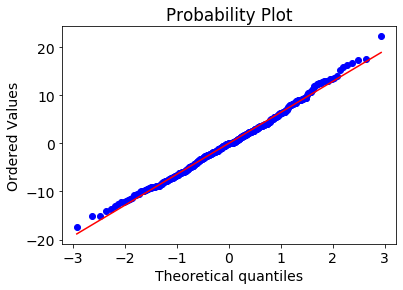

L:  5


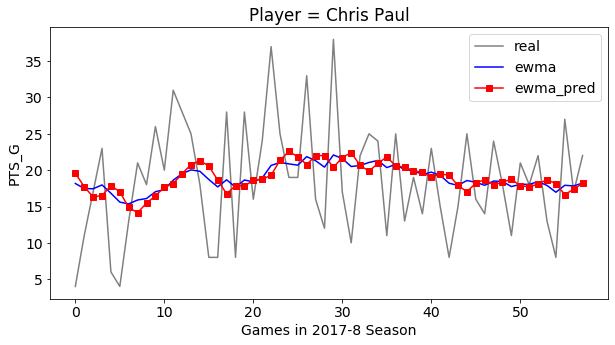

Chris Paul
*** RMSE compared to ewma ***
first 0-5 games:  1.1433247418185093
first 5-10 games:  1.0948774800358827
first 10-20 games:  1.0839569162760054
all           :  0.9781395161363872

Chris Paul
*** RMSE baseline for ewma (pred = last observation)***
first 0-5 games:  0.9242155690303827
first 5-10 games:  0.7446862352812877
first 10-20 games:  0.9036396377177511
all           :  0.7586952362875669
Chris Paul
*** RMSE compared to actual***
first 0-5 games:  9.714333897675354
first 5-10 games:  7.9608007868383455
first 10-20 games:  9.328836990139196
all           :  8.005375325062701
Chris Paul
*** RMSE baseline for actual (pred = last observation)***
first 0-5 games:  10.761040841851685
first 5-10 games:  6.663332499583072
first 10-20 games:  12.345039489608771
all           :  10.669809163532724


In [1010]:
# player_name = "LeBron James"
# L = 10

metric = "PTS_G"
span = 20
nbrSingValuesToKeep = 2
xlabel = 'Games in 2017-8 Season'
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"

#############
for player_name in player_list_1:
    print()
    print("------------------------------------------------------------------")
    player_stat = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
#     player_stat_ewma = player_stat.ewm(span=span).mean()
    player_stat_ewma = run_ewma(player_stat, span)
    player_stat_ewma = pd.Series(player_stat_ewma, name=player_name)
    player_residual = (player_stat - player_stat_ewma)
    
    L = int(np.floor(np.sqrt(len(player_stat.to_list())/10)))
    
    player_page = page_mat(player_stat.to_list(), L)
    u, s_original, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_stat_ewma.to_list(), L)
    u, s_ewma, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(player_residual.to_list(), L)
    u, s_residual, vh = np.linalg.svd(player_page)
    
    # singval spectrum
    plt.title(player_name+"; L={}".format(L))
    plt.plot(s_original, label= "original")
    plt.plot(s_ewma, label="ewma; span={}".format(span))
    plt.plot(s_residual, label="residual")
    plt.legend()
    plt.show()
    
    # histogram
    plt.title(player_name+"; histogram of the residuals")
    plt.hist(player_residual, bins=100)
    plt.show()
    
    # qq plot
    stats.probplot(player_residual, dist="norm", plot=pylab)
    pylab.show()
    
    # prediction plot
    plt.figure(figsize=(10,5))
    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]

    # true data
    player_data = player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    preDF = player_stat.loc[player_stat.date <= interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    postDF = player_stat.loc[player_stat.date > interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    n = preDF.shape[0]
    plt.plot(postDF, label="real", color="grey")

    # ewma data
    # player_data_ewma = player_data.ewm(span=span).mean()
    player_data_ewma = run_ewma(player_data, span)
    player_data_ewma = pd.DataFrame(player_data_ewma, columns=[player_name])
    preDF_ewma = player_data_ewma[:n].reset_index(drop=True)
    postDF_ewma = player_data_ewma[n:].reset_index(drop=True)
    plt.plot(postDF_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred = ts_estimate(preDF_ewma, postDF_ewma, player_name, nbrSingValuesToKeep)
    plt.plot(ts_pred[:-1], label="ewma_pred", color="red", marker='s')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.title('Player = '+player_name)
    plt.show()

    true = postDF_ewma.values.flatten()
    print(player_name)
    print("*** RMSE compared to ewma ***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    print()
    
    pred = postDF_ewma.shift(+1).values
    pred[0] = preDF_ewma.iloc[-1]
    true = postDF_ewma.values
    print(player_name)
    print("*** RMSE baseline for ewma (pred = last observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]))
    print("all           : ", rmse(true, pred))
    
    true = postDF.values.flatten()
    print(player_name)
    print("*** RMSE compared to actual***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    
    pred = postDF.shift(+1).values
    pred[0] = preDF.iloc[-1]
    true = postDF.values
    print(player_name)
    print("*** RMSE baseline for actual (pred = last observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]))
    print("all           : ", rmse(true, pred))
    

In [598]:
from statsmodels.tsa.stattools import adfuller

In [625]:
def test_rolling_stat(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def test_dickey_fuller(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

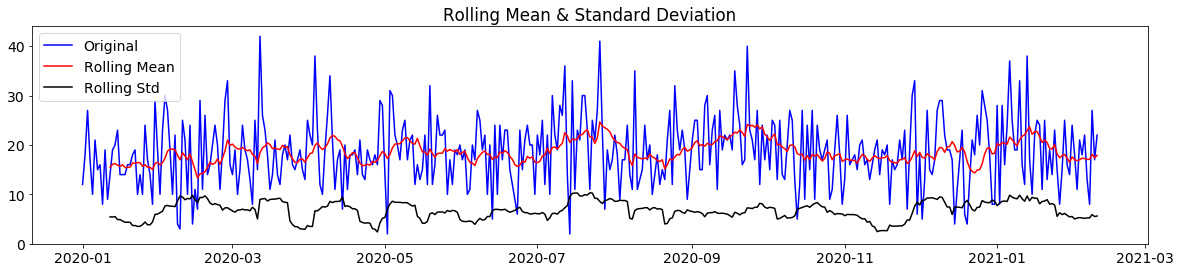

In [626]:
player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
player_data = player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
player_data.index = pd.date_range('2020-01-01', periods=player_data.shape[0], freq='D')

test_rolling_stat(player_data)


In [636]:
test_dickey_fuller(player_data)

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

# Time Series Decomposition + Predict Trend

In [673]:
def time_series_decomposition(player_data):
    player_data.index = pd.date_range('2020-01-01', periods=player_data.shape[0], freq='D')
    
    decomposition = seasonal_decompose(player_data)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    print()
    print("************", player_name, "************")
    plt.figure(figsize=(20,8))
    plt.subplot(411)
    plt.plot(player_data, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return trend, residual

-----------------------------------------------------------------------------------

************ Stephen Curry ************


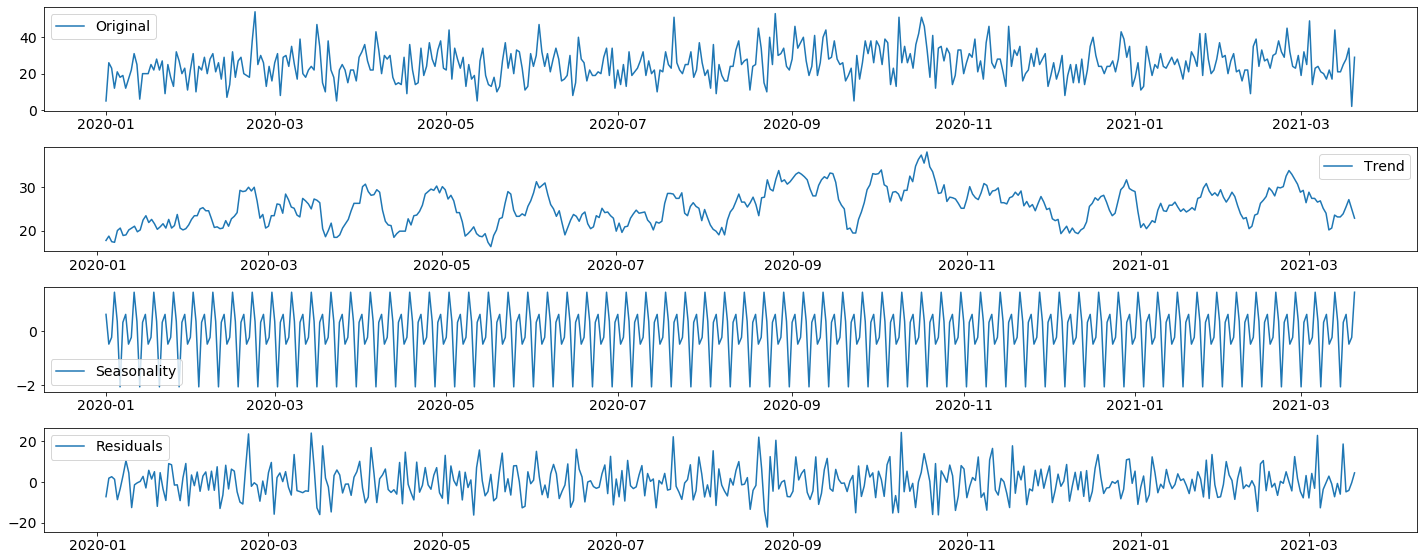

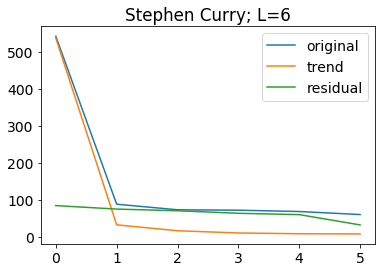

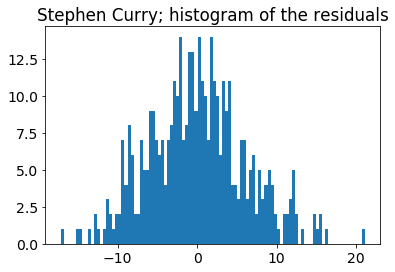

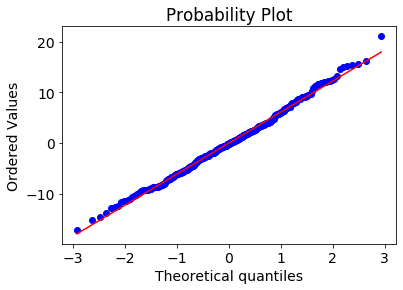

L:  6


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


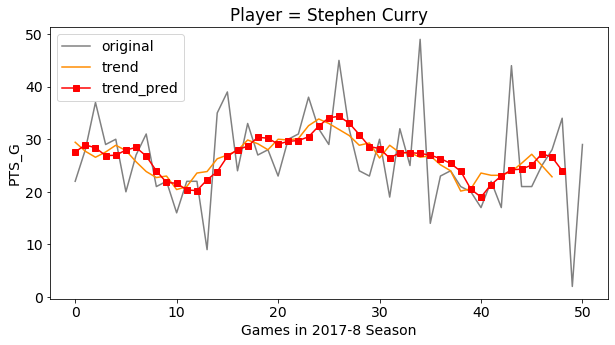

Stephen Curry
*** RMSE compared to trend ***
first 0-5 games:  1.5606924305864633
first 5-10 games:  1.960251543415061
first 10-20 games:  1.7136242937218955
all           :  nan

*** RMSE baseline for trend (pred = last trend observation)***
first 0-5 games:  1.3370695950625822
first 5-10 games:  1.4442002235542983
first 10-20 games:  1.6307003628715449
all           :  1.6144015971891268
Stephen Curry
*** RMSE compared to actual***
first 0-5 games:  4.901768488887462
first 5-10 games:  4.289691571158959
first 10-20 games:  7.353424604865817
all           :  nan

*** RMSE baseline for original (pred = last original observation)***
first 0-5 games:  6.099180272790763
first 5-10 games:  7.293833011524188
first 10-20 games:  11.29601699715435
all           :  12.366146070116226

-----------------------------------------------------------------------------------

************ LeBron James ************


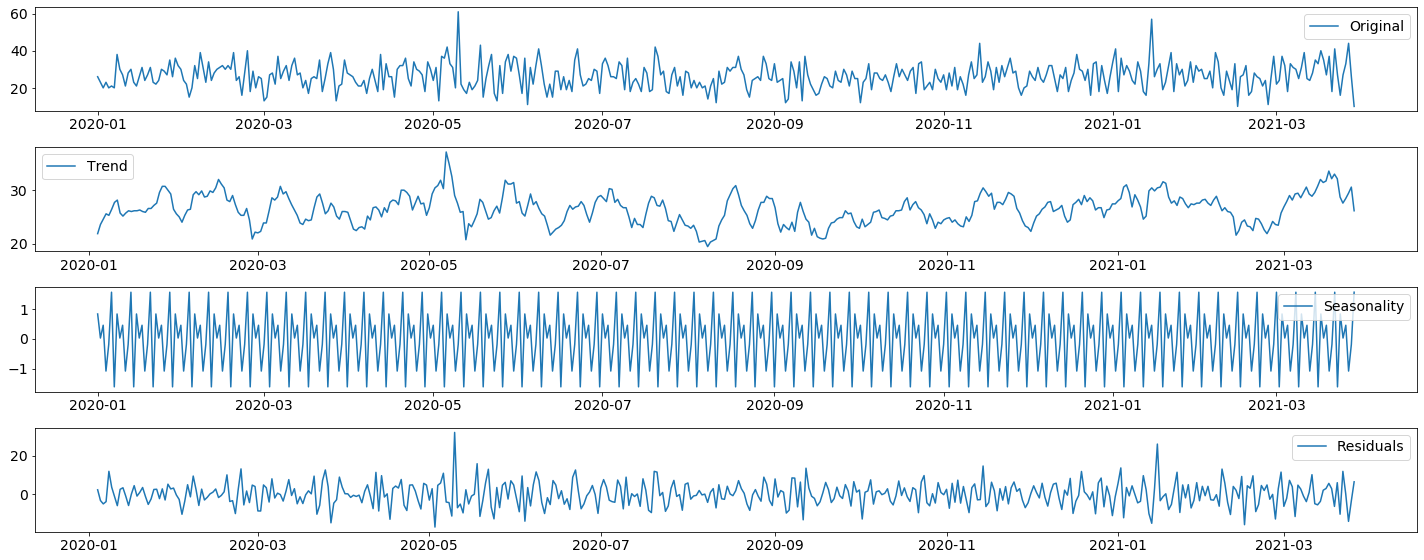

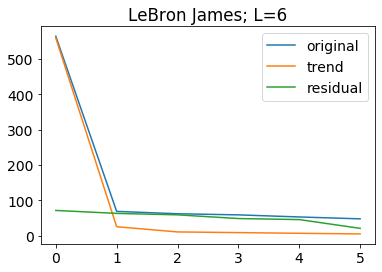

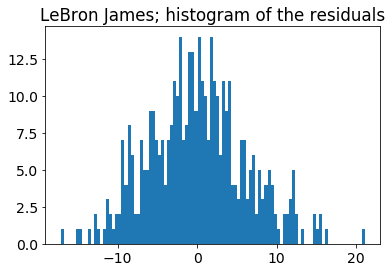

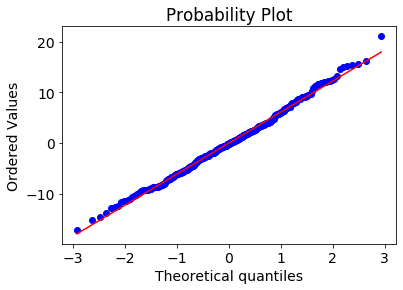

L:  6


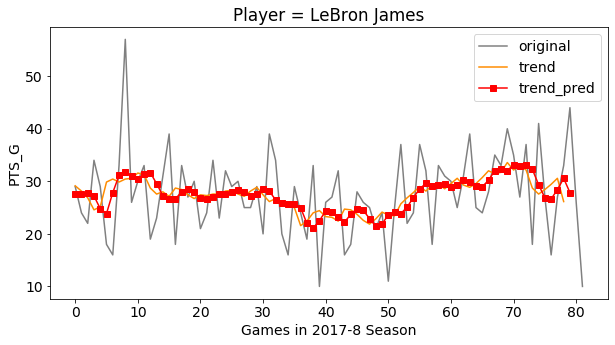

LeBron James
*** RMSE compared to trend ***
first 0-5 games:  1.456103872527502
first 5-10 games:  3.032050203223764
first 10-20 games:  1.474689258268437
all           :  nan

*** RMSE baseline for trend (pred = last trend observation)***
first 0-5 games:  1.6388149028228574
first 5-10 games:  2.1552025332167
first 10-20 games:  1.182353239803346
all           :  1.3727803765656212
LeBron James
*** RMSE compared to actual***
first 0-5 games:  4.705764770371821
first 5-10 games:  12.990008838541211
first 10-20 games:  6.9019737860017525
all           :  nan

*** RMSE baseline for original (pred = last original observation)***
first 0-5 games:  6.434283176858165
first 5-10 games:  19.75348070594142
first 10-20 games:  10.373041983911952
all           :  11.056396449070755

-----------------------------------------------------------------------------------

************ Al Horford ************


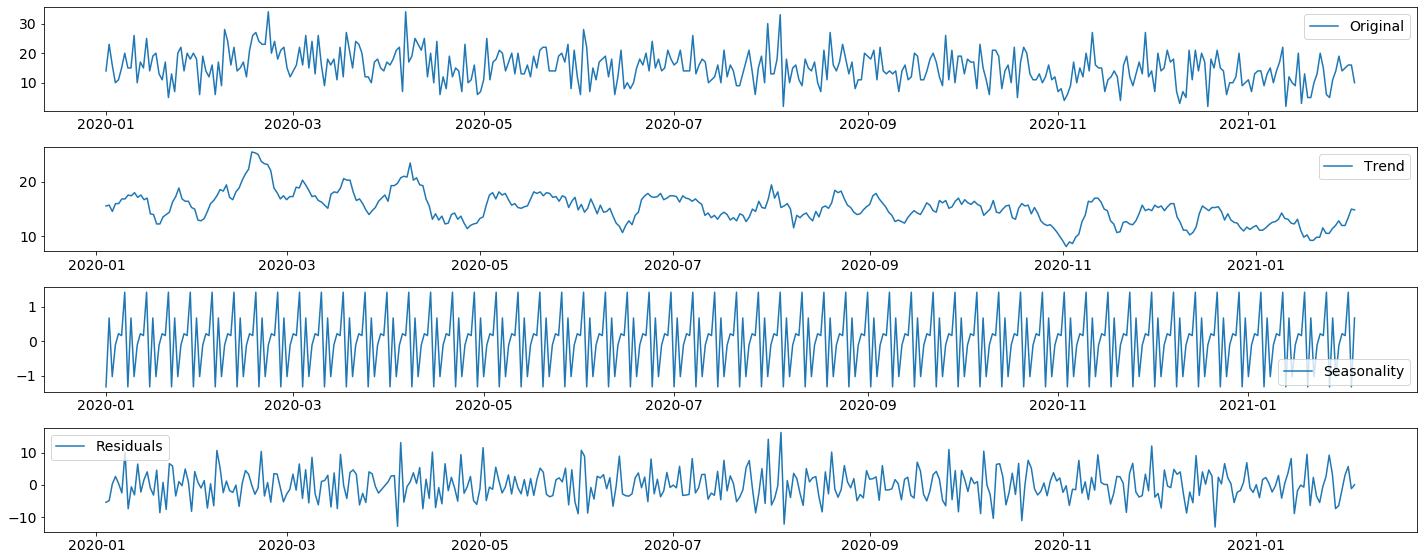

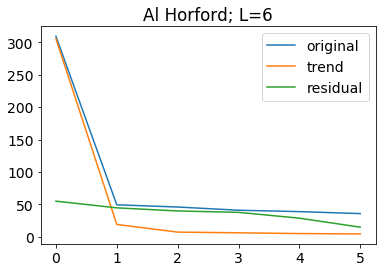

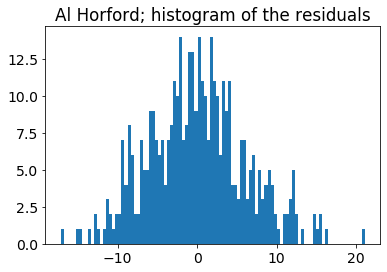

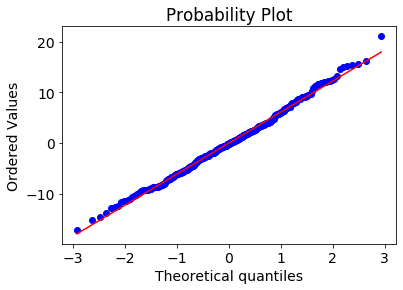

L:  5


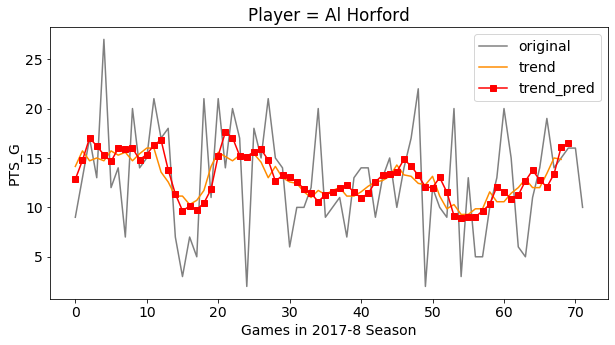

Al Horford
*** RMSE compared to trend ***
first 0-5 games:  1.4001875317636654
first 5-10 games:  0.8570648524683674
first 10-20 games:  1.504533414823814
all           :  nan

*** RMSE baseline for trend (pred = last trend observation)***
first 0-5 games:  1.028174526596946
first 5-10 games:  0.7085483867221274
first 10-20 games:  1.3069672013123061
all           :  0.9251809418780917
Al Horford
*** RMSE compared to actual***
first 0-5 games:  5.73470589103619
first 5-10 games:  4.6184822256785925
first 10-20 games:  4.982647486408994
all           :  nan

*** RMSE baseline for original (pred = last original observation)***
first 0-5 games:  7.113367697511496
first 5-10 games:  9.828529900244492
first 10-20 games:  7.52994023880668
all           :  7.365459931328117

-----------------------------------------------------------------------------------

************ Trevor Ariza ************


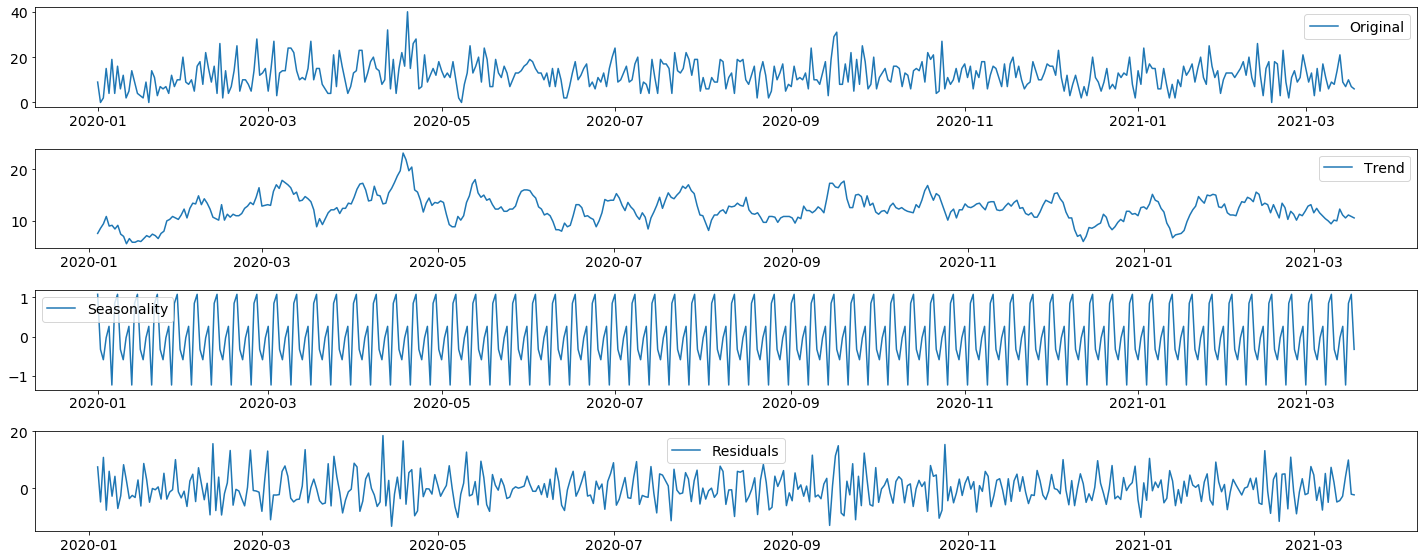

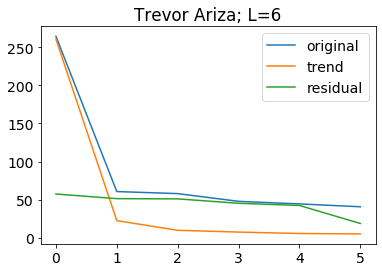

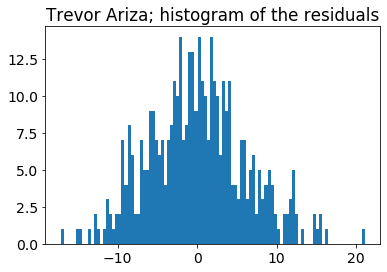

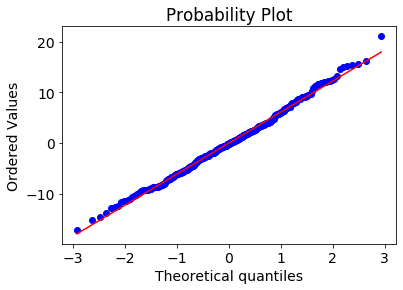

L:  6


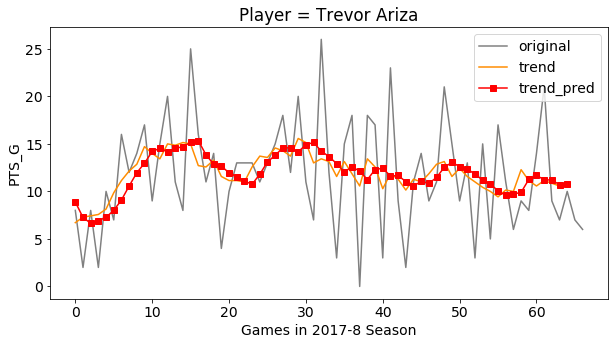

Trevor Ariza
*** RMSE compared to trend ***
first 0-5 games:  1.1405895663514893
first 5-10 games:  1.671242661953939
first 10-20 games:  1.1078431790089114
all           :  nan

*** RMSE baseline for trend (pred = last trend observation)***
first 0-5 games:  0.9102589898327992
first 5-10 games:  1.3821013282797519
first 10-20 games:  1.1010199353141534
all           :  1.1344557267334705
Trevor Ariza
*** RMSE compared to actual***
first 0-5 games:  3.518118148106897
first 5-10 games:  3.7745300563737283
first 10-20 games:  5.475285684330228
all           :  nan

*** RMSE baseline for original (pred = last original observation)***
first 0-5 games:  6.648308055437865
first 5-10 games:  4.878524367060187
first 10-20 games:  8.47938677028003
all           :  8.39420553519892



In [775]:
metric = "PTS_G"
span = 5
nbrSingValuesToKeep = 2
xlabel = 'Games in 2017-8 Season'
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"

##############################################
for player_name in player_list:
    print("-----------------------------------------------------------------------------------")

    # trend data
    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
    player_data = player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    trend, residual = time_series_decomposition(player_data)
    
#     # entropy
#     b = trend.dropna()
#     a = pd.DataFrame(0, index=b.index, columns=b.columns)
#     a[b.shift(+1) - b >0] = 1
#     a = list(a.values.flatten())
#     calculate_compress_rate(a, quality)
#     print()
#     print("baseline (upper) ")
#     saeyoung(a)
#     print()
#     print("baseline (lower) ")
#     dennis(a)

    # true data
    preDF = player_stat.loc[player_stat.date <= interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    postDF = player_stat.loc[player_stat.date > interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    n = preDF.shape[0]
    
    L = int(np.floor(np.sqrt(len(player_data.values.flatten())/10)))
    
    player_page = page_mat(player_data.dropna(axis=0).values.flatten(), L)
    u, s_original, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(trend.dropna(axis=0).values.flatten(), L)
    u, s_trend, vh = np.linalg.svd(player_page)
    
    player_page = page_mat(residual.dropna(axis=0).values.flatten(), L)
    u, s_residual, vh = np.linalg.svd(player_page)
    
    # sigval spectrum
    plt.title(player_name+"; L={}".format(L))
    # plt.ylim(0,100)
    plt.plot(s_original, label= "original")
    plt.plot(s_trend, label="trend")
    plt.plot(s_residual, label="residual")
    plt.legend()
    plt.show()
    
    # histogram
    plt.title(player_name+"; histogram of the residuals")
    plt.hist(player_residual, bins=100)
    plt.show()
    
    # qq plot
    stats.probplot(player_residual, dist="norm", plot=pylab)
    pylab.show()

    # prediction plot
    plt.figure(figsize=(10,5))
    plt.plot(postDF, label="original", color="grey")
    plt.plot(trend[n:].values.flatten(), label="trend", color="darkorange")
    
    # trend pred
    ts_pred = ts_estimate(trend[:n], trend[n:], player_name, nbrSingValuesToKeep)
    plt.plot(ts_pred[:-1], label="trend_pred", color="red", marker='s')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.title('Player = '+player_name)
    plt.show()

    print("============================")
    true = trend[n:].values.flatten()
    print(player_name)
    print("*** RMSE compared to trend ***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    print()
    
    # baseline
    pred = trend[(n-1):].shift(+1)[1:]
    true = trend[n:]
    print("*** RMSE baseline for trend (pred = last trend observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]).values[0])
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]).values[0])
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]).values[0])
    print("all           : ", rmse(true, pred).values[0])
    
    
    print("============================")
    true = postDF.values.flatten()
    print(player_name)
    print("*** RMSE compared to actual***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    print()
    
    # baseline
    pred = postDF.shift(+1).values
    pred[0] = preDF.iloc[-1]
    true = postDF.values
    print("*** RMSE baseline for original (pred = last original observation)***")
    print("first 0-5 games: ", rmse(true[0:5], pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], pred[10:20]))
    print("all           : ", rmse(true, pred))
    print()
    
#     print("============================")
#     pred = trend[(n-1):].shift(+1)[1:]
#     true = postDF.values
#     print("*** RMSE (pred = last trend observation, true = original observation)***")
#     print("first 0-5 games: ", rmse(true[0:5], pred[0:5]).values[0])
#     print("first 5-10 games: ", rmse(true[5:10], pred[5:10]).values[0])
#     print("first 10-20 games: ", rmse(true[10:20], pred[10:20]).values[0])
#     print("all           : ", rmse(true, pred).values[0])
#     print()

    

# ACF, PACF

In [696]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [ ]:
metric = "PTS_G"
span = 5
nbrSingValuesToKeep = 2
xlabel = 'Games in 2017-8 Season'
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"

##############################################
for player_name in player_list:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]

    # true data
    player_data = player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    preDF = player_stat.loc[player_stat.date <= interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    postDF = player_stat.loc[player_stat.date > interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    n = preDF.shape[0]
    plt.plot(postDF, label="real", color="grey")

    # ewma data
    # player_data_ewma = player_data.ewm(span=span).mean()
    player_data_ewma = run_ewma(player_data, span)
    player_data_ewma = pd.DataFrame(player_data_ewma, columns=[player_name])
    preDF_ewma = player_data_ewma[:n].reset_index(drop=True)
    postDF_ewma = player_data_ewma[n:].reset_index(drop=True)
    plt.plot(postDF_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred = ts_estimate(preDF_ewma, postDF_ewma, player_name, nbrSingValuesToKeep)
    plt.plot(ts_pred[:-1], label="ewma_pred", color="red", marker='s')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.title('Player = '+player_name)
    plt.show()

    true = postDF_ewma.values.flatten()
    print(player_name)
    print("*** RMSE compared to ewma ***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))
    
    true = postDF.values.flatten()
    print(player_name)
    print("*** RMSE compared to actual***")
    print("first 0-5 games: ", rmse(true[0:5], ts_pred[0:5]))
    print("first 5-10 games: ", rmse(true[5:10], ts_pred[5:10]))
    print("first 10-20 games: ", rmse(true[10:20], ts_pred[10:20]))
    print("all           : ", rmse(true, ts_pred[:-1]))